In [82]:
import h5py
import scanpy as sc
import anndata
import loompy as lp

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sys
import glob
import importlib

In [73]:
import sys
sys.path.insert(0, '/home/tchari/monod/src/')

In [74]:
import monod
importlib.reload(monod)
from monod import preprocess, extract_data, cme_toolbox, analysis, mminference

In [75]:
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score

## **Checking meK-Means performance with simulated dropout**

In [17]:
d_strings  = glob.glob('/home/tchari/counts/meKMeans_sims/loom/*.loom')
d_strings 

['/home/tchari/counts/meKMeans_sims/loom/drop_1perc_sim_k8.loom',
 '/home/tchari/counts/meKMeans_sims/loom/drop_5perc_sim_k8.loom',
 '/home/tchari/counts/meKMeans_sims/loom/drop_20perc_sim_k8.loom',
 '/home/tchari/counts/meKMeans_sims/loom/negctrl_sim_k1.loom',
 '/home/tchari/counts/meKMeans_sims/loom/b_beta_sim_k8.loom',
 '/home/tchari/counts/meKMeans_sims/loom/k_gamma_sim_k8.loom']

In [18]:
attribute_names =[('unspliced','spliced'),'gene_name','barcode']

In [19]:
datas = [i.replace('/home/tchari/counts/meKMeans_sims/loom/','') for i in d_strings]
datas = [i.replace('.loom','') for i in datas]

In [20]:
to_run = [0,1,2,4] #inds to run

In [21]:
samp = [-6.777777777777778, -1.25]

In [22]:
transcriptomes = '/home/tchari/perturbCME/notebooks/sim_genome_polyA_cum_3_0'

In [53]:
sub_d_strings = [d_strings[i] for i in to_run]
sub_d_strings

['/home/tchari/counts/meKMeans_sims/loom/drop_1perc_sim_k8.loom',
 '/home/tchari/counts/meKMeans_sims/loom/drop_5perc_sim_k8.loom',
 '/home/tchari/counts/meKMeans_sims/loom/drop_20perc_sim_k8.loom',
 '/home/tchari/counts/meKMeans_sims/loom/b_beta_sim_k8.loom']

In [56]:
datas_sub = [datas[i] for i in to_run]
datas_sub

['drop_1perc_sim_k8',
 'drop_5perc_sim_k8',
 'drop_20perc_sim_k8',
 'b_beta_sim_k8']

In [57]:
#For each loom in looms from ./hvg_objs

# !mkdir /home/tchari/perturbCME/notebooks/fits/meKruns_0209
!mkdir /home/tchari/perturbCME/notebooks/fits/meKruns_0309


dir_strings = []
data_strings = []
result_strings = []

#Save method, clustering, mat_in (U,S, etc), hyper (K or res), hvgs, data, ARI, AMI
meK_res = pd.DataFrame()
meths = []
result = []
mats = []
hyper = []
hvgs = []
data = []
ari = []
ami = []

for d in sub_d_strings: #************* FASTER FOR NOW ************* 
    
    #Get tech param by keyword (datas) in loom paths
    ind = [i in d for i in datas_sub]
    
    #Inference params for sampling
    tech_tup = samp
    
    #Preprocessing params for filepaths
    trans = transcriptomes

    data_name = np.array(datas_sub)[ind][0]
    
    
    ds = lp.connect(d)
    g_names = ds.ra[attribute_names[1]]
    num_genes = len(g_names)
    num_cells = len(ds.ca[attribute_names[2]])
    
    U = ds.layers['unspliced'][:,:].T
    S = ds.layers['spliced'][:,:].T
    true_labs = list(ds.ca['subclass_label'])
    ds.close()

    
    print(data_name+' with '+str(num_genes)+' genes')
    
    
   
    Ks = [5,len(np.unique(true_labs)),len(np.unique(true_labs))+5,len(np.unique(true_labs))+10]
        

    for clus in Ks:
       
        #Run Monod preprocessing to set up files for run, leave room for genes to be removed with low U/S
        dir_string,dataset_string = monod.preprocess.construct_batch([d], \
                                                     trans, \
                                                     [data_name], \
                                                     attribute_names=attribute_names,\
                                                     batch_location='./fits/meKruns_0309', \
                                                     meta=data_name+'_K'+str(clus), \
                                                     batch_id=1, \
                                                     n_genes=num_genes,exp_filter_threshold=None,
                                                                     viz=False,genes_to_fit=g_names)
                                                        #num_genes-60 or 100,genes_to_fit=markers
        dir_strings += [dir_string]
        data_strings += [dataset_string]

        #Set model and run meK-Means
        
        #Define bounds for params
        phys_lb = [-3.0, -3, -3 ] 
        phys_ub = [4.2, 2.5, 2.5] 
        samp_lb = tech_tup 
        samp_ub = tech_tup  
        gridsize = [1,1] #Already have tech params
    

        epochs = 10

        # ---------------- meK-Means Inference ---------------- 
        #Define model with bursty transcription and Poisson molecule capture/sampling
        fitmodel = monod.cme_toolbox.CMEModel('Bursty','Poisson')

        #Set up mminference parameters
        inference_parameters = monod.mminference.InferenceParameters(phys_lb,phys_ub,samp_lb,samp_ub,gridsize,\
                    dataset_string[0],fitmodel,k=clus,epochs=epochs,use_lengths = True,
                    gradient_params = {'max_iterations':5,'init_pattern':'moments','num_restarts':1})

        #Read in loom file with filtered barcodes
        search_data = monod.extract_data.extract_data(d, trans, data_name,
                    dataset_string[0], dir_string, viz=False, dataset_attr_names=attribute_names)

        #Run inference(fit_all_grid_points()) and Save result file strings
        full_result_string = inference_parameters.fit_all_grid_points(40,search_data) 

        result_strings.append(full_result_string)
        

        # ----------------  Save output ---------------- 
        #Read in results and get cluster assignments
        sr = [monod.analysis.load_search_results(i) for i in full_result_string]
        
        
        cat_assigns = np.array([None]*num_cells) #cat_assigns is empty list of length = no. cell barcodes
        for i in range(len(sr)):
            r = sr[i]
            cat_assigns[r.filt] = r.assigns #denotes which cluster (k), cells were assigned to

        print('No. clus: ',len(np.unique(cat_assigns)))
        

        meths += ['meK-Means']
        result += [cat_assigns]
        mats += ['U,S']
        hyper += [clus]
        hvgs += [num_genes]
        data += [data_name]
        ari += [adjusted_rand_score(true_labs,cat_assigns)]
        ami += [adjusted_mutual_info_score(true_labs,cat_assigns)]
        
        print('ARI: ',adjusted_rand_score(true_labs,cat_assigns))


meK_res['Method'] = meths
meK_res['Clustering'] = result
meK_res['Matrices'] = mats
meK_res['Hyperparam'] = hyper
meK_res['Genes'] = hvgs
meK_res['Data'] = data
meK_res['ARI'] = ari
meK_res['AMI'] = ami
    

mkdir: cannot create directory ‘/home/tchari/perturbCME/notebooks/fits/meKruns_0309’: File exists
drop_1perc_sim_k8 with 1100 genes


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:38<00:00, 19.79s/it]


mstep self.weights:  [0.26159552 0.2721219  0.16241235 0.19870171 0.10516852]
Q Function:  -7568047.611773815



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:37<00:00, 19.40s/it]


mstep self.weights:  [0.26019768 0.28590224 0.16000056 0.19389361 0.10000592]
Q Function:  -7555654.429106488



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:46<00:00, 21.29s/it]


mstep self.weights:  [0.26042816 0.28562544 0.16024532 0.19380721 0.09989387]
Q Function:  -7563334.125453163



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:41<00:00, 20.39s/it]


mstep self.weights:  [0.2604547  0.28624094 0.16021582 0.19328865 0.09979989]
Q Function:  -7563926.773928804



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:38<00:00, 19.77s/it]


mstep self.weights:  [0.26049912 0.28649101 0.16021576 0.19299431 0.0997998 ]
Q Function:  -7563833.022394094



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:38<00:00, 19.65s/it]


mstep self.weights:  [0.26048521 0.28681125 0.16021646 0.1926873  0.09979978]
Q Function:  -7564528.990949209



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:38<00:00, 19.79s/it]


mstep self.weights:  [0.26048587 0.28671992 0.16021801 0.19277638 0.09979982]
Q Function:  -7563842.557523256



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:37<00:00, 19.57s/it]


mstep self.weights:  [0.26057043 0.28676816 0.1602176  0.19264396 0.09979985]
Q Function:  -7564643.679365889



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:39<00:00, 19.84s/it]


mstep self.weights:  [0.26048591 0.28671992 0.16021801 0.19277633 0.09979983]
Q Function:  -7563842.55813856



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:49<00:00, 21.82s/it]


mstep self.weights:  [0.26057043 0.28676816 0.1602176  0.19264396 0.09979985]
Q Function:  -7564643.679366443

No. clus:  5
ARI:  0.7833126422901235


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:54<00:00, 11.46s/it]


mstep self.weights:  [0.15992098 0.06925715 0.16526704 0.10304447 0.06946628 0.11831583
 0.00790359 0.09472902 0.02690418 0.18519146]
Q Function:  -7605886.079598464



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [01:40<00:00, 11.15s/it]


mstep self.weights:  [1.61826040e-01 2.82445575e-02 1.99192229e-01 1.00312730e-01
 7.90515864e-02 1.19038331e-01 2.00000000e-10 6.00495057e-02
 1.93250230e-02 2.32959997e-01]
Q Function:  -7562372.080484992



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [01:45<00:00, 11.68s/it]


mstep self.weights:  [1.62412955e-01 2.24455979e-03 2.01053629e-01 1.00606975e-01
 7.77193519e-02 1.32791177e-01 2.00000000e-10 4.93889932e-02
 1.17167328e-02 2.62065626e-01]
Q Function:  -7556099.506787338



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [01:54<00:00, 14.29s/it]


mstep self.weights:  [1.61431486e-01 2.00000000e-10 2.01089337e-01 1.00230768e-01
 7.82105233e-02 1.51846810e-01 2.00000000e-10 4.34371474e-02
 1.44893564e-03 2.62304994e-01]
Q Function:  -7558680.78512952



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:39<00:00, 14.20s/it]


mstep self.weights:  [1.60278207e-01 2.00000000e-10 1.99325779e-01 1.00082080e-01
 7.70996410e-02 1.62718220e-01 2.00000000e-10 3.99093906e-02
 2.00000000e-10 2.60586683e-01]
Q Function:  -7552060.294443328



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:38<00:00, 14.05s/it]


mstep self.weights:  [1.60333189e-01 2.00000000e-10 1.98072969e-01 9.99895401e-02
 7.54649418e-02 1.57011428e-01 2.00000000e-10 4.86176995e-02
 2.00000000e-10 2.60510232e-01]
Q Function:  -7555677.240003579



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:40<00:00, 14.41s/it]


mstep self.weights:  [1.60193867e-01 2.00000000e-10 1.97689748e-01 1.00002476e-01
 6.95368030e-02 1.67218576e-01 2.00000000e-10 4.49108773e-02
 2.00000000e-10 2.60447652e-01]
Q Function:  -7556203.862892037



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:41<00:00, 14.54s/it]


mstep self.weights:  [1.60232049e-01 2.00000000e-10 1.98557723e-01 9.99933569e-02
 7.29853741e-02 1.55907108e-01 2.00000000e-10 5.20662482e-02
 2.00000000e-10 2.60258140e-01]
Q Function:  -7551383.827409003



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:39<00:00, 14.24s/it]


mstep self.weights:  [1.60449119e-01 2.00000000e-10 1.99965014e-01 1.00105304e-01
 7.03631601e-02 1.55319245e-01 2.00000000e-10 5.31251583e-02
 2.00000000e-10 2.60672999e-01]
Q Function:  -7552947.885483929



100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [01:42<00:00,  6.81s/it]


mstep self.weights:  [0.05520601 0.07919717 0.01630834 0.02127851 0.13065607 0.06225744
 0.13184161 0.21211544 0.01616089 0.11266531 0.03436997 0.01976557
 0.03220092 0.04817035 0.02780639]
Q Function:  -7639036.916926831



100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [01:44<00:00,  6.95s/it]


mstep self.weights:  [0.10489666 0.02482394 0.00063523 0.00763272 0.17276246 0.07900304
 0.11309111 0.219121   0.00749867 0.16535147 0.06350615 0.00519057
 0.00643697 0.0286494  0.0014006 ]
Q Function:  -7583581.754137765



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [01:39<00:00, 11.09s/it]


mstep self.weights:  [1.02019757e-01 9.97540474e-03 1.99999999e-10 4.11584796e-10
 1.90252444e-01 8.55262724e-02 5.24591004e-02 2.46084869e-01
 2.00000016e-10 2.14482799e-01 8.80313274e-02 1.99999999e-10
 1.99999999e-10 1.11680254e-02 1.99999999e-10]
Q Function:  -7573099.753351096



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:38<00:00, 14.04s/it]


mstep self.weights:  [1.00381396e-01 1.99999999e-10 1.99999999e-10 1.99999999e-10
 1.98211719e-01 8.05970327e-02 3.89796794e-02 2.59465379e-01
 1.99999999e-10 2.23108437e-01 9.92563549e-02 1.99999999e-10
 1.99999999e-10 2.00000464e-10 1.99999999e-10]
Q Function:  -7569479.5872639455



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:38<00:00, 14.05s/it]


mstep self.weights:  [1.00060508e-01 1.99999999e-10 1.99999999e-10 1.99999999e-10
 2.00015774e-01 7.83661179e-02 1.06323126e-02 2.60978288e-01
 1.99999999e-10 2.49944631e-01 1.00002368e-01 1.99999999e-10
 1.99999999e-10 1.99999999e-10 1.99999999e-10]
Q Function:  -7562942.380835318



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:37<00:00, 16.29s/it]


mstep self.weights:  [9.99758461e-02 1.99999999e-10 1.99999999e-10 1.99999999e-10
 2.00276571e-01 8.31852954e-02 1.99999999e-10 2.54523456e-01
 1.99999999e-10 2.62037185e-01 1.00001644e-01 1.99999999e-10
 1.99999999e-10 1.99999999e-10 1.99999999e-10]
Q Function:  -7562810.435499576



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:39<00:00, 16.56s/it]


mstep self.weights:  [1.00001439e-01 1.99999999e-10 1.99999999e-10 1.99999999e-10
 2.01639714e-01 9.69318583e-02 1.99999999e-10 2.39093537e-01
 1.99999999e-10 2.62231961e-01 1.00101488e-01 1.99999999e-10
 1.99999999e-10 1.99999999e-10 1.99999999e-10]
Q Function:  -7563550.159243486



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:37<00:00, 16.31s/it]


mstep self.weights:  [9.99959458e-02 1.99999999e-10 1.99999999e-10 1.99999999e-10
 2.02541889e-01 1.06789699e-01 1.99999999e-10 2.29020490e-01
 1.99999999e-10 2.61469458e-01 1.00182516e-01 1.99999999e-10
 1.99999999e-10 1.99999999e-10 1.99999999e-10]
Q Function:  -7562162.345597677



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:37<00:00, 16.28s/it]


mstep self.weights:  [9.99486466e-02 1.99999999e-10 1.99999999e-10 1.99999999e-10
 2.01206553e-01 1.09719442e-01 1.99999999e-10 2.27849100e-01
 1.99999999e-10 2.61011543e-01 1.00264714e-01 1.99999999e-10
 1.99999999e-10 1.99999999e-10 1.99999999e-10]
Q Function:  -7561335.743832428



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:39<00:00, 16.55s/it]


mstep self.weights:  [1.00013721e-01 1.99999999e-10 1.99999999e-10 1.99999999e-10
 2.01022693e-01 1.15230456e-01 1.99999999e-10 2.21947269e-01
 1.99999999e-10 2.61382706e-01 1.00403154e-01 1.99999999e-10
 1.99999999e-10 1.99999999e-10 1.99999999e-10]
Q Function:  -7561969.997769229

No. clus:  6
ARI:  0.8854422457409612


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:57<00:00,  5.87s/it]


mstep self.weights:  [0.02445448 0.04003553 0.0634728  0.01180199 0.01441002 0.04377956
 0.02052489 0.02125087 0.02169985 0.00530351 0.17572865 0.00155212
 0.04198119 0.07492562 0.1050746  0.03367034 0.02466302 0.18478007
 0.01860295 0.07228795]
Q Function:  -7662757.927019322



100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [01:43<00:00,  6.89s/it]


mstep self.weights:  [4.60921722e-03 3.33595977e-03 3.53578429e-02 2.00000005e-10
 1.32896775e-08 1.43264453e-01 2.00402120e-10 7.30256314e-03
 4.25830504e-03 1.99999999e-10 2.85074135e-01 1.99999999e-10
 9.68494687e-03 6.28435261e-02 1.20063076e-01 1.11922887e-02
 4.98043193e-03 2.58901755e-01 2.23825652e-03 4.68932282e-02]
Q Function:  -7619767.346461119



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:41<00:00, 14.56s/it]


mstep self.weights:  [1.99999999e-10 1.99999999e-10 3.13022522e-02 1.99999999e-10
 2.00003448e-10 1.59835919e-01 1.99999999e-10 1.99999999e-10
 1.99999999e-10 1.99999999e-10 3.12769764e-01 1.99999999e-10
 1.99999999e-10 3.51815317e-02 7.33071220e-02 9.85126969e-05
 1.99999999e-10 3.63462456e-01 1.99999999e-10 2.40424395e-02]
Q Function:  -7592423.669118112



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:40<00:00, 14.34s/it]


mstep self.weights:  [1.99999999e-10 1.99999999e-10 3.26972867e-02 1.99999999e-10
 2.00000561e-10 1.60284718e-01 1.99999999e-10 1.99999999e-10
 1.99999999e-10 1.99999999e-10 3.28128831e-01 1.99999999e-10
 1.99999999e-10 2.25741967e-02 5.47264471e-02 4.76513204e-08
 1.99999999e-10 4.01297656e-01 1.99999999e-10 2.90814461e-04]
Q Function:  -7581244.143441622



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:39<00:00, 16.51s/it]


mstep self.weights:  [1.99999999e-10 1.99999999e-10 6.12786275e-03 1.99999999e-10
 2.00000086e-10 1.60204460e-01 1.99999999e-10 1.99999999e-10
 1.99999999e-10 1.99999999e-10 3.06795958e-01 1.99999999e-10
 1.99999999e-10 1.75736028e-02 4.42726550e-02 4.25954725e-10
 1.99999999e-10 4.65025459e-01 1.99999999e-10 1.99999999e-10]
Q Function:  -7582337.991870173



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:37<00:00, 19.58s/it]


mstep self.weights:  [1.99999999e-10 1.99999999e-10 1.99999999e-10 1.99999999e-10
 2.00097227e-10 1.60638912e-01 1.99999999e-10 1.99999999e-10
 1.99999999e-10 1.99999999e-10 3.01609551e-01 1.99999999e-10
 1.99999999e-10 1.26582438e-02 1.62949393e-02 2.00840439e-10
 1.99999999e-10 5.08798352e-01 1.99999999e-10 1.99999999e-10]
Q Function:  -7589031.022635088



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [01:51<00:00, 27.81s/it]


mstep self.weights:  [1.99999999e-10 1.99999999e-10 1.99999999e-10 1.99999999e-10
 2.00020963e-10 1.60533571e-01 1.99999999e-10 1.99999999e-10
 1.99999999e-10 1.99999999e-10 2.65078636e-01 1.99999999e-10
 1.99999999e-10 1.04596527e-02 2.72193655e-06 2.13884039e-10
 1.99999999e-10 5.63925416e-01 1.99999999e-10 1.99999999e-10]
Q Function:  -7586980.221612248



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:42<00:00, 34.14s/it]


mstep self.weights:  [1.99999999e-10 1.99999999e-10 1.99999999e-10 1.99999999e-10
 2.00000682e-10 1.60465744e-01 1.99999999e-10 1.99999999e-10
 1.99999999e-10 1.99999999e-10 2.53574260e-01 1.99999999e-10
 1.99999999e-10 1.82116894e-08 1.03465580e-08 2.00880784e-10
 1.99999999e-10 5.85959964e-01 1.99999999e-10 1.99999999e-10]
Q Function:  -7589981.320793945



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:38<00:00, 32.71s/it]


mstep self.weights:  [1.99999999e-10 1.99999999e-10 1.99999999e-10 1.99999999e-10
 2.00000166e-10 1.60399114e-01 1.99999999e-10 1.99999999e-10
 1.99999999e-10 1.99999999e-10 2.33362276e-01 1.99999999e-10
 1.99999999e-10 2.00000356e-10 2.63029575e-10 2.00541586e-10
 1.99999999e-10 6.06238607e-01 1.99999999e-10 1.99999999e-10]
Q Function:  -7591414.170122894



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:37<00:00, 32.53s/it]


mstep self.weights:  [1.99999999e-10 1.99999999e-10 1.99999999e-10 1.99999999e-10
 2.00000008e-10 1.60378780e-01 1.99999999e-10 1.99999999e-10
 1.99999999e-10 1.99999999e-10 2.03674804e-01 1.99999999e-10
 1.99999999e-10 2.00000002e-10 2.07131746e-10 2.03324856e-10
 1.99999999e-10 6.35946413e-01 1.99999999e-10 1.99999999e-10]
Q Function:  -7593075.498322133

No. clus:  3
ARI:  0.3409676150867976
drop_5perc_sim_k8 with 1100 genes


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:39<00:00, 19.86s/it]


mstep self.weights:  [0.16618776 0.17883833 0.25675879 0.11445432 0.2837608 ]
Q Function:  -7417253.095942982



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:49<00:00, 21.99s/it]


mstep self.weights:  [0.16001869 0.1956885  0.2600181  0.10028495 0.28398977]
Q Function:  -7386605.085205177



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:38<00:00, 19.61s/it]


mstep self.weights:  [0.16019747 0.19547958 0.26024416 0.10014997 0.28392882]
Q Function:  -7394786.195308584



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:39<00:00, 19.82s/it]


mstep self.weights:  [0.16027661 0.19486308 0.26030173 0.10013044 0.28442815]
Q Function:  -7395567.807524108



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:37<00:00, 19.52s/it]


mstep self.weights:  [0.16028126 0.19689249 0.26023737 0.10011376 0.28247512]
Q Function:  -7392195.998191699



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:38<00:00, 19.62s/it]


mstep self.weights:  [0.16029392 0.19748163 0.26023696 0.10015125 0.28183625]
Q Function:  -7392880.7768468475



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:39<00:00, 19.98s/it]


mstep self.weights:  [0.16029159 0.19656485 0.26022922 0.10015871 0.28275563]
Q Function:  -7395049.529137992



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:39<00:00, 19.96s/it]


mstep self.weights:  [0.16029423 0.19795094 0.26028529 0.10013048 0.28133906]
Q Function:  -7392537.452460942



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:41<00:00, 20.23s/it]


mstep self.weights:  [0.1602883  0.19587849 0.26023219 0.10014914 0.28345188]
Q Function:  -7395673.512435714



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:39<00:00, 19.94s/it]


mstep self.weights:  [0.16030333 0.19779943 0.26025805 0.10011895 0.28152024]
Q Function:  -7392571.979733193

No. clus:  5
ARI:  0.7962156839212243


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:40<00:00, 10.03s/it]


mstep self.weights:  [0.08870832 0.17111056 0.12869574 0.01458872 0.0608021  0.21165963
 0.09201811 0.06504831 0.10524048 0.06212803]
Q Function:  -7434110.777545386



100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:42<00:00, 10.26s/it]


mstep self.weights:  [0.10179819 0.20130277 0.12210554 0.00605976 0.04196598 0.26114761
 0.10155379 0.00170874 0.12880172 0.03355589]
Q Function:  -7384329.525366795



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [01:39<00:00, 12.38s/it]


mstep self.weights:  [1.08890786e-01 2.01577704e-01 1.22504882e-01 4.91688574e-08
 4.25187059e-02 2.62155786e-01 1.00884276e-01 2.00000000e-10
 1.54781165e-01 6.68664493e-03]
Q Function:  -7385981.833080457



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:40<00:00, 14.36s/it]


mstep self.weights:  [1.09483891e-01 2.02147076e-01 1.24721709e-01 2.00000007e-10
 3.97430681e-02 2.61924488e-01 1.00638135e-01 2.00000000e-10
 1.61341631e-01 2.00000000e-10]
Q Function:  -7381663.05119068



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:40<00:00, 14.30s/it]


mstep self.weights:  [1.10076701e-01 1.99883798e-01 1.29135746e-01 2.00000000e-10
 3.80299691e-02 2.61391661e-01 1.00566713e-01 2.00000000e-10
 1.60915411e-01 2.00000000e-10]
Q Function:  -7382538.428332016



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:41<00:00, 14.52s/it]


mstep self.weights:  [1.10987799e-01 1.99216846e-01 1.28781429e-01 2.00000000e-10
 3.70206816e-02 2.62108063e-01 1.00517200e-01 2.00000000e-10
 1.61367980e-01 2.00000000e-10]
Q Function:  -7387590.419555551



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:39<00:00, 14.26s/it]


mstep self.weights:  [1.10481998e-01 1.99208457e-01 1.30111042e-01 2.00000000e-10
 3.69867367e-02 2.61973885e-01 1.00402836e-01 2.00000000e-10
 1.60835044e-01 2.00000000e-10]
Q Function:  -7384313.071919854



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:40<00:00, 14.31s/it]


mstep self.weights:  [1.12576119e-01 1.99871866e-01 1.27620065e-01 2.00000000e-10
 3.69588327e-02 2.61607923e-01 1.00377530e-01 2.00000000e-10
 1.60987664e-01 2.00000000e-10]
Q Function:  -7385535.280172726



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:43<00:00, 14.76s/it]


mstep self.weights:  [1.12971427e-01 1.98512727e-01 1.29244540e-01 2.00000000e-10
 3.69643689e-02 2.60853213e-01 1.00394292e-01 2.00000000e-10
 1.61059432e-01 2.00000000e-10]
Q Function:  -7389058.897309547



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:40<00:00, 14.41s/it]


mstep self.weights:  [1.10380330e-01 1.99263215e-01 1.30741037e-01 2.00000000e-10
 3.71589910e-02 2.61332304e-01 1.00396524e-01 2.00000000e-10
 1.60727598e-01 2.00000000e-10]
Q Function:  -7385550.521067705

No. clus:  7
ARI:  0.9401512129180424


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [01:43<00:00,  6.92s/it]


mstep self.weights:  [0.05778415 0.04489292 0.01671931 0.17653823 0.05836232 0.09559034
 0.06449304 0.21599288 0.01573639 0.0378275  0.01612438 0.04629341
 0.08997175 0.03703611 0.02663725]
Q Function:  -7473157.0831457395



100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [01:46<00:00,  7.11s/it]


mstep self.weights:  [0.00713585 0.01069459 0.0011597  0.22215456 0.08738363 0.16078023
 0.05070559 0.1851459  0.0005167  0.01442229 0.00128586 0.01082125
 0.2304134  0.00804321 0.00933723]
Q Function:  -7417686.596424112



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:42<00:00, 14.62s/it]


mstep self.weights:  [1.99999999e-10 2.98547333e-10 1.99999999e-10 2.42292071e-01
 9.76566477e-02 1.97364489e-01 3.67164667e-02 1.64926659e-01
 1.99999999e-10 9.02596287e-04 1.99999999e-10 1.99999999e-10
 2.60141069e-01 2.00036867e-10 1.99999999e-10]
Q Function:  -7394720.1902296515



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:38<00:00, 16.36s/it]


mstep self.weights:  [1.99999999e-10 1.99999999e-10 1.99999999e-10 2.67900945e-01
 9.89371162e-02 1.97052946e-01 1.61193322e-02 1.59987840e-01
 1.99999999e-10 1.99999999e-10 1.99999999e-10 1.99999999e-10
 2.60001819e-01 1.99999999e-10 1.99999999e-10]
Q Function:  -7392157.004676038



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:41<00:00, 16.86s/it]


mstep self.weights:  [1.99999999e-10 1.99999999e-10 1.99999999e-10 2.85922093e-01
 9.91250188e-02 1.93624941e-01 1.19849172e-03 1.60008527e-01
 1.99999999e-10 1.99999999e-10 1.99999999e-10 1.99999999e-10
 2.60120927e-01 1.99999999e-10 1.99999999e-10]
Q Function:  -7396248.461151317



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:38<00:00, 19.73s/it]


mstep self.weights:  [1.99999999e-10 1.99999999e-10 1.99999999e-10 2.86036082e-01
 9.92106836e-02 1.94321255e-01 1.99999999e-10 1.60202464e-01
 1.99999999e-10 1.99999999e-10 1.99999999e-10 1.99999999e-10
 2.60229513e-01 1.99999999e-10 1.99999999e-10]
Q Function:  -7397764.586806271



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:38<00:00, 19.79s/it]


mstep self.weights:  [1.99999999e-10 1.99999999e-10 1.99999999e-10 2.86727970e-01
 9.92220716e-02 1.93528558e-01 1.99999999e-10 1.60268057e-01
 1.99999999e-10 1.99999999e-10 1.99999999e-10 1.99999999e-10
 2.60253342e-01 1.99999999e-10 1.99999999e-10]
Q Function:  -7399103.274026652



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:47<00:00, 21.46s/it]


mstep self.weights:  [1.99999999e-10 1.99999999e-10 1.99999999e-10 2.84499298e-01
 9.92214157e-02 1.95768224e-01 1.99999999e-10 1.60263341e-01
 1.99999999e-10 1.99999999e-10 1.99999999e-10 1.99999999e-10
 2.60247718e-01 1.99999999e-10 1.99999999e-10]
Q Function:  -7395939.480444862



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:39<00:00, 19.88s/it]


mstep self.weights:  [1.99999999e-10 1.99999999e-10 1.99999999e-10 2.85819403e-01
 9.92167155e-02 1.94437891e-01 1.99999999e-10 1.60275738e-01
 1.99999999e-10 1.99999999e-10 1.99999999e-10 1.99999999e-10
 2.60250250e-01 1.99999999e-10 1.99999999e-10]
Q Function:  -7397624.9708276605



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:48<00:00, 21.63s/it]


mstep self.weights:  [1.99999999e-10 1.99999999e-10 1.99999999e-10 2.83454811e-01
 9.92160197e-02 1.96828547e-01 1.99999999e-10 1.60274359e-01
 1.99999999e-10 1.99999999e-10 1.99999999e-10 1.99999999e-10
 2.60226261e-01 1.99999999e-10 1.99999999e-10]
Q Function:  -7394421.238670407

No. clus:  5
ARI:  0.7919202168465697


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:51<00:00,  5.57s/it]


mstep self.weights:  [0.00818982 0.01065237 0.03450455 0.01774916 0.0259641  0.00309317
 0.01012521 0.05226873 0.04494856 0.03831399 0.12355361 0.00468924
 0.06451644 0.0773471  0.07860543 0.05182265 0.10201496 0.18757237
 0.03017407 0.03389447]
Q Function:  -7494025.3071877295



100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [01:45<00:00,  7.54s/it]


mstep self.weights:  [1.99999999e-10 1.99999999e-10 3.35990994e-03 1.58329298e-04
 8.91862071e-03 1.99999999e-10 1.99999999e-10 2.91464785e-03
 1.24671660e-02 8.77523620e-03 6.23818222e-02 1.99999999e-10
 1.01331383e-01 8.10849836e-02 1.23516035e-01 2.66386195e-02
 1.46933846e-01 3.85084358e-01 1.71683274e-02 1.92667143e-02]
Q Function:  -7456941.839749273



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [01:53<00:00, 12.58s/it]


mstep self.weights:  [1.99999999e-10 1.99999999e-10 1.99999999e-10 9.92784254e-08
 3.89084163e-08 1.99999999e-10 1.99999999e-10 1.99999999e-10
 2.32471083e-07 2.29758280e-10 4.44673305e-03 1.99999999e-10
 1.52002853e-01 6.77078971e-02 1.72775318e-01 4.10481432e-03
 1.78293792e-01 4.11051829e-01 1.02146789e-03 8.59492410e-03]
Q Function:  -7437607.88646687



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:43<00:00, 20.62s/it]


mstep self.weights:  [1.99999999e-10 1.99999999e-10 1.99999999e-10 2.00005958e-10
 2.00000501e-10 1.99999999e-10 1.99999999e-10 1.99999999e-10
 2.00003310e-10 1.99999999e-10 1.99999999e-10 1.99999999e-10
 1.92374288e-01 3.16390231e-02 1.60663139e-01 1.99999999e-10
 1.69892448e-01 4.45431048e-01 1.99999999e-10 5.07793205e-08]
Q Function:  -7413427.310610394



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:43<00:00, 20.68s/it]


mstep self.weights:  [1.99999999e-10 1.99999999e-10 1.99999999e-10 2.00001025e-10
 2.00000000e-10 1.99999999e-10 1.99999999e-10 1.99999999e-10
 2.00000001e-10 1.99999999e-10 1.99999999e-10 1.99999999e-10
 1.95297110e-01 2.27336780e-03 1.60020897e-01 1.99999999e-10
 1.87560778e-01 4.54847844e-01 1.99999999e-10 2.00011703e-10]
Q Function:  -7409545.792652374



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [01:32<00:00, 23.08s/it]


mstep self.weights:  [1.99999999e-10 1.99999999e-10 1.99999999e-10 2.00000060e-10
 2.00000001e-10 1.99999999e-10 1.99999999e-10 1.99999999e-10
 2.00000001e-10 1.99999999e-10 1.99999999e-10 1.99999999e-10
 1.93744336e-01 1.99999999e-10 1.60249284e-01 1.99999999e-10
 2.14399887e-01 4.31606491e-01 1.99999999e-10 2.00000555e-10]
Q Function:  -7412254.547359539



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [01:35<00:00, 23.86s/it]


mstep self.weights:  [1.99999999e-10 1.99999999e-10 1.99999999e-10 2.00000026e-10
 1.99999999e-10 1.99999999e-10 1.99999999e-10 1.99999999e-10
 2.00000000e-10 1.99999999e-10 1.99999999e-10 1.99999999e-10
 1.93118461e-01 1.99999999e-10 1.60250781e-01 1.99999999e-10
 2.43553815e-01 4.03076939e-01 1.99999999e-10 2.00000151e-10]
Q Function:  -7413629.032333828



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [01:47<00:00, 26.84s/it]


mstep self.weights:  [1.99999999e-10 1.99999999e-10 1.99999999e-10 2.00000001e-10
 1.99999999e-10 1.99999999e-10 1.99999999e-10 1.99999999e-10
 2.00000000e-10 1.99999999e-10 1.99999999e-10 1.99999999e-10
 1.93012420e-01 1.99999999e-10 1.60254804e-01 1.99999999e-10
 2.56902708e-01 3.89830065e-01 1.99999999e-10 2.00000632e-10]
Q Function:  -7410136.312271426



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [01:42<00:00, 25.51s/it]


mstep self.weights:  [1.99999999e-10 1.99999999e-10 1.99999999e-10 2.00000005e-10
 1.99999999e-10 1.99999999e-10 1.99999999e-10 1.99999999e-10
 2.00000001e-10 1.99999999e-10 1.99999999e-10 1.99999999e-10
 1.92397611e-01 1.99999999e-10 1.60029211e-01 1.99999999e-10
 2.87586563e-01 3.59986612e-01 1.99999999e-10 2.00000300e-10]
Q Function:  -7407440.335620652



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [01:34<00:00, 23.66s/it]


mstep self.weights:  [1.99999999e-10 1.99999999e-10 1.99999999e-10 2.00000000e-10
 1.99999999e-10 1.99999999e-10 1.99999999e-10 1.99999999e-10
 2.00000001e-10 1.99999999e-10 1.99999999e-10 1.99999999e-10
 1.92255329e-01 1.99999999e-10 1.60000268e-01 1.99999999e-10
 2.91174652e-01 3.56569747e-01 1.99999999e-10 2.00000701e-10]
Q Function:  -7404798.437409741

No. clus:  4
ARI:  0.6474662109586186
drop_20perc_sim_k8 with 1100 genes


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:33<00:00, 18.80s/it]


mstep self.weights:  [0.17488227 0.11510725 0.26311439 0.16365386 0.28324223]
Q Function:  -6717986.986769881



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:37<00:00, 19.58s/it]


mstep self.weights:  [0.17999921 0.10044015 0.25547786 0.16026471 0.30381806]
Q Function:  -6706325.324991708



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:40<00:00, 20.20s/it]


mstep self.weights:  [0.17779942 0.09968097 0.25506784 0.16040081 0.30705096]
Q Function:  -6710216.055610943



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:45<00:00, 21.14s/it]


mstep self.weights:  [0.17708371 0.0997209  0.25768789 0.16037163 0.30513587]
Q Function:  -6704266.445740743



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:46<00:00, 21.37s/it]


mstep self.weights:  [0.17832152 0.09969933 0.25730318 0.16036116 0.30431481]
Q Function:  -6705311.631315181



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:34<00:00, 18.98s/it]


mstep self.weights:  [0.17655895 0.09946407 0.256201   0.16032035 0.30745563]
Q Function:  -6707194.581889851



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:33<00:00, 18.65s/it]


mstep self.weights:  [0.17999479 0.09940146 0.25603461 0.16038299 0.30418617]
Q Function:  -6706693.605126548



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:33<00:00, 18.66s/it]


mstep self.weights:  [0.18057665 0.09941549 0.25578071 0.16037869 0.30384845]
Q Function:  -6707100.222018163



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:33<00:00, 18.75s/it]


mstep self.weights:  [0.18346109 0.09942312 0.25492414 0.16034301 0.30184865]
Q Function:  -6709250.964322782



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:48<00:00, 21.73s/it]


mstep self.weights:  [0.18511794 0.09942339 0.25530044 0.16031517 0.29984305]
Q Function:  -6706048.929158595

No. clus:  5
ARI:  0.7416323464647934


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:37<00:00,  9.75s/it]


mstep self.weights:  [0.0465393  0.15271075 0.17515627 0.03133391 0.13583018 0.09450957
 0.02871319 0.09960925 0.08966809 0.1459295 ]
Q Function:  -6739628.069309121



100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:39<00:00,  9.95s/it]


mstep self.weights:  [0.04223671 0.16083508 0.1690906  0.0131929  0.11617504 0.09606543
 0.00376257 0.11790532 0.09655283 0.18418351]
Q Function:  -6713713.777821278



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [01:38<00:00, 10.98s/it]


mstep self.weights:  [4.23265524e-02 2.13021175e-01 1.66236442e-01 2.84635605e-03
 1.08040034e-01 4.80681143e-02 2.00000000e-10 1.35973568e-01
 9.14815253e-02 1.92006233e-01]
Q Function:  -6701278.185174759



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:39<00:00, 14.24s/it]


mstep self.weights:  [3.90320657e-02 2.61269355e-01 1.63121971e-01 2.00000000e-10
 1.04175711e-01 2.50405469e-04 2.00000000e-10 1.42131290e-01
 9.77132123e-02 1.92305990e-01]
Q Function:  -6698818.448665455



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:35<00:00, 13.59s/it]


mstep self.weights:  [2.93755583e-02 2.59754558e-01 1.62873590e-01 2.00000000e-10
 1.02301822e-01 3.82294614e-05 2.00000000e-10 1.54696570e-01
 9.85395055e-02 1.92420166e-01]
Q Function:  -6705536.587041334



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:36<00:00, 13.76s/it]


mstep self.weights:  [2.10412083e-02 2.59676892e-01 1.62953850e-01 2.00000000e-10
 1.01289884e-01 5.10204127e-06 2.00000000e-10 1.66320825e-01
 9.58436732e-02 1.92868566e-01]
Q Function:  -6706118.5473012915



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:37<00:00, 13.89s/it]


mstep self.weights:  [5.09150493e-03 2.60122690e-01 1.62264151e-01 2.00000000e-10
 1.00357782e-01 6.18394119e-07 2.00000000e-10 1.87749967e-01
 9.18127642e-02 1.92600523e-01]
Q Function:  -6701361.936574372



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:35<00:00, 15.99s/it]


mstep self.weights:  [2.00000000e-10 2.58965100e-01 1.61936088e-01 2.00000000e-10
 1.00717266e-01 2.20773917e-08 2.00000000e-10 1.97680888e-01
 8.83739575e-02 1.92326677e-01]
Q Function:  -6701468.736703339



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:39<00:00, 16.62s/it]


mstep self.weights:  [2.00000000e-10 2.58928611e-01 1.61614618e-01 2.00000000e-10
 1.00385490e-01 6.57597739e-10 2.00000000e-10 2.02536693e-01
 8.39888040e-02 1.92545783e-01]
Q Function:  -6701047.888627232



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:36<00:00, 16.08s/it]


mstep self.weights:  [2.00000000e-10 2.58777376e-01 1.61657555e-01 2.00000000e-10
 1.00361333e-01 2.15149148e-10 2.00000000e-10 2.03767185e-01
 8.34564373e-02 1.91980112e-01]
Q Function:  -6700673.970873284

No. clus:  6
ARI:  0.8642614650553411


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [01:39<00:00,  6.65s/it]


mstep self.weights:  [0.09176136 0.15354807 0.03283305 0.07694322 0.05467043 0.02472042
 0.02827339 0.06328761 0.00224263 0.13395026 0.00790173 0.0577018
 0.07460983 0.04424655 0.15330964]
Q Function:  -6770363.701042821



100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [01:38<00:00,  7.56s/it]


mstep self.weights:  [1.26312390e-01 1.92989352e-01 2.20300173e-02 2.09720586e-02
 2.54630400e-02 3.78490180e-03 8.74055292e-03 9.80538843e-02
 1.99999999e-10 1.76801266e-01 1.99999999e-10 1.07754615e-02
 4.36252178e-02 1.39932456e-02 2.56458612e-01]
Q Function:  -6728045.947122608



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [01:41<00:00, 11.27s/it]


mstep self.weights:  [1.86309856e-01 2.10510335e-01 1.21822427e-02 5.94134490e-04
 4.11578409e-04 1.99999999e-10 1.99999999e-10 1.00368303e-01
 1.99999999e-10 1.79954124e-01 1.99999999e-10 2.00000003e-10
 4.42045256e-02 1.35749699e-04 2.65329150e-01]
Q Function:  -6725437.0732142795



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:38<00:00, 14.11s/it]


mstep self.weights:  [2.28585843e-01 2.01463029e-01 4.35929588e-04 1.99999999e-10
 1.99999999e-10 1.99999999e-10 1.99999999e-10 9.86657370e-02
 1.99999999e-10 1.67245246e-01 1.99999999e-10 1.99999999e-10
 4.19979759e-02 4.05569008e-10 2.61606238e-01]
Q Function:  -6709008.941524621



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:36<00:00, 16.05s/it]


mstep self.weights:  [2.55150918e-01 1.96215556e-01 1.99999999e-10 1.99999999e-10
 1.99999999e-10 1.99999999e-10 1.99999999e-10 9.74901383e-02
 1.99999999e-10 1.70791165e-01 1.99999999e-10 1.99999999e-10
 2.03124210e-02 2.00000219e-10 2.60039800e-01]
Q Function:  -6713387.797868637



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:34<00:00, 15.73s/it]


mstep self.weights:  [2.82479085e-01 1.95319901e-01 1.99999999e-10 1.99999999e-10
 1.99999999e-10 1.99999999e-10 1.99999999e-10 9.56781786e-02
 1.99999999e-10 1.61966294e-01 1.99999999e-10 1.99999999e-10
 5.92728050e-03 2.00001357e-10 2.58629260e-01]
Q Function:  -6708808.53080829



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:32<00:00, 18.56s/it]


mstep self.weights:  [2.93637954e-01 1.94148257e-01 1.99999999e-10 1.99999999e-10
 1.99999999e-10 1.99999999e-10 1.99999999e-10 9.49428387e-02
 1.99999999e-10 1.60659380e-01 1.99999999e-10 1.99999999e-10
 1.99999999e-10 2.00000218e-10 2.56611569e-01]
Q Function:  -6715602.5729966145



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:33<00:00, 18.77s/it]


mstep self.weights:  [2.95341154e-01 1.93205954e-01 1.99999999e-10 1.99999999e-10
 1.99999999e-10 1.99999999e-10 1.99999999e-10 9.45765627e-02
 1.99999999e-10 1.60263594e-01 1.99999999e-10 1.99999999e-10
 1.99999999e-10 2.00000060e-10 2.56612733e-01]
Q Function:  -6705408.21783913



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:33<00:00, 18.63s/it]


mstep self.weights:  [2.98285673e-01 1.92033880e-01 1.99999999e-10 1.99999999e-10
 1.99999999e-10 1.99999999e-10 1.99999999e-10 9.39660674e-02
 1.99999999e-10 1.60201020e-01 1.99999999e-10 1.99999999e-10
 1.99999999e-10 2.00000006e-10 2.55513357e-01]
Q Function:  -6705236.13972666



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:50<00:00, 22.02s/it]


mstep self.weights:  [2.98190716e-01 1.92192972e-01 1.99999999e-10 1.99999999e-10
 1.99999999e-10 1.99999999e-10 1.99999999e-10 9.40234672e-02
 1.99999999e-10 1.60221287e-01 1.99999999e-10 1.99999999e-10
 1.99999999e-10 2.00000075e-10 2.55371556e-01]
Q Function:  -6707178.709003965

No. clus:  5
ARI:  0.7524997954586476


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:49<00:00,  5.47s/it]


mstep self.weights:  [0.08190291 0.0401182  0.03219693 0.01943191 0.01513707 0.00800232
 0.09318153 0.01598282 0.11797421 0.08435183 0.05652611 0.01416857
 0.11606362 0.04288876 0.02576861 0.034351   0.02162019 0.15770546
 0.01711832 0.00550962]
Q Function:  -6786210.913129165



100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [01:57<00:00,  7.82s/it]


mstep self.weights:  [8.52762276e-02 1.12710461e-02 6.42518848e-03 2.60860184e-06
 2.20151863e-04 1.99999999e-10 1.97633888e-02 1.76061111e-04
 1.72394739e-01 6.40256702e-02 1.09185990e-02 3.45405881e-10
 1.84896943e-01 6.45170802e-02 1.55896825e-03 3.44814799e-03
 3.88757261e-04 3.74716422e-01 2.00983338e-10 1.99999999e-10]
Q Function:  -6758769.951517584



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:49<00:00, 15.60s/it]


mstep self.weights:  [1.13823099e-01 2.00282950e-10 1.99999999e-10 2.00031874e-10
 1.99999999e-10 1.99999999e-10 1.50672960e-03 1.99999999e-10
 1.81348615e-01 3.14618356e-02 1.99999999e-10 2.00000001e-10
 1.91155005e-01 1.01211101e-01 1.99999999e-10 1.99999999e-10
 1.99999999e-10 3.79493612e-01 1.99999999e-10 1.99999999e-10]
Q Function:  -6736714.324294043



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:50<00:00, 18.34s/it]


mstep self.weights:  [1.36571308e-01 1.99999999e-10 1.99999999e-10 2.00000000e-10
 1.99999999e-10 1.99999999e-10 1.99999999e-10 1.99999999e-10
 1.56001377e-01 4.59416761e-03 1.99999999e-10 1.99999999e-10
 2.09454420e-01 1.37402180e-01 1.99999999e-10 1.99999999e-10
 1.99999999e-10 3.55976545e-01 1.99999999e-10 1.99999999e-10]
Q Function:  -6720965.548109151



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:34<00:00, 18.90s/it]


mstep self.weights:  [1.37531299e-01 1.99999999e-10 1.99999999e-10 2.00000002e-10
 1.99999999e-10 1.99999999e-10 1.99999999e-10 1.99999999e-10
 1.44481611e-01 1.99999999e-10 1.99999999e-10 1.99999999e-10
 2.02919252e-01 1.57678205e-01 1.99999999e-10 1.99999999e-10
 1.99999999e-10 3.57389629e-01 1.99999999e-10 1.99999999e-10]
Q Function:  -6717031.671112247



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:42<00:00, 20.58s/it]


mstep self.weights:  [1.68033451e-01 1.99999999e-10 1.99999999e-10 1.99999999e-10
 1.99999999e-10 1.99999999e-10 1.99999999e-10 1.99999999e-10
 1.53825558e-01 1.99999999e-10 1.99999999e-10 1.99999999e-10
 1.54233134e-01 1.60412586e-01 1.99999999e-10 1.99999999e-10
 1.99999999e-10 3.63495268e-01 1.99999999e-10 1.99999999e-10]
Q Function:  -6709707.977012318



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:46<00:00, 21.36s/it]


mstep self.weights:  [1.70022305e-01 1.99999999e-10 1.99999999e-10 1.99999999e-10
 1.99999999e-10 1.99999999e-10 1.99999999e-10 1.99999999e-10
 1.40465844e-01 1.99999999e-10 1.99999999e-10 1.99999999e-10
 1.82424784e-01 1.60389927e-01 1.99999999e-10 1.99999999e-10
 1.99999999e-10 3.46697137e-01 1.99999999e-10 1.99999999e-10]
Q Function:  -6712712.553249883



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:41<00:00, 20.23s/it]


mstep self.weights:  [1.75415198e-01 1.99999999e-10 1.99999999e-10 1.99999999e-10
 1.99999999e-10 1.99999999e-10 1.99999999e-10 1.99999999e-10
 1.42745771e-01 1.99999999e-10 1.99999999e-10 1.99999999e-10
 1.72714914e-01 1.60424520e-01 1.99999999e-10 1.99999999e-10
 1.99999999e-10 3.48699594e-01 1.99999999e-10 1.99999999e-10]
Q Function:  -6708640.152243927



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:46<00:00, 21.21s/it]


mstep self.weights:  [1.90943368e-01 1.99999999e-10 1.99999999e-10 1.99999999e-10
 1.99999999e-10 1.99999999e-10 1.99999999e-10 1.99999999e-10
 1.52761941e-01 1.99999999e-10 1.99999999e-10 1.99999999e-10
 1.45623553e-01 1.61651870e-01 1.99999999e-10 1.99999999e-10
 1.99999999e-10 3.49019266e-01 1.99999999e-10 1.99999999e-10]
Q Function:  -6711640.274193969



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:33<00:00, 18.65s/it]


mstep self.weights:  [1.85303447e-01 1.99999999e-10 1.99999999e-10 1.99999999e-10
 1.99999999e-10 1.99999999e-10 1.99999999e-10 1.99999999e-10
 1.42447433e-01 1.99999999e-10 1.99999999e-10 1.99999999e-10
 1.76405399e-01 1.60612414e-01 1.99999999e-10 1.99999999e-10
 1.99999999e-10 3.35231304e-01 1.99999999e-10 1.99999999e-10]
Q Function:  -6709216.158297593

No. clus:  5
ARI:  0.7261684855161804
b_beta_sim_k8 with 1100 genes


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:50<00:00, 22.13s/it]


mstep self.weights:  [0.26023482 0.16111113 0.1012406  0.19926465 0.2781488 ]
Q Function:  -7619700.473605821



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:34<00:00, 18.91s/it]


mstep self.weights:  [0.26031704 0.16040563 0.0999982  0.1983319  0.28094723]
Q Function:  -7599408.832341096



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:33<00:00, 18.73s/it]


mstep self.weights:  [0.26011211 0.16041445 0.09993976 0.19865887 0.28087482]
Q Function:  -7599631.658773062



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:45<00:00, 21.10s/it]


mstep self.weights:  [0.26001483 0.16003111 0.09996314 0.19741935 0.28257156]
Q Function:  -7595779.789325077



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:44<00:00, 20.84s/it]


mstep self.weights:  [0.26035276 0.16022255 0.09991022 0.19652047 0.282994  ]
Q Function:  -7600733.808607715



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:46<00:00, 21.30s/it]


mstep self.weights:  [0.2602127  0.16006675 0.09995032 0.19428296 0.28548727]
Q Function:  -7596428.229604573



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:47<00:00, 21.50s/it]


mstep self.weights:  [0.26040837 0.16022987 0.09991794 0.19357584 0.28586797]
Q Function:  -7604000.509412809



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:50<00:00, 22.16s/it]


mstep self.weights:  [0.26026964 0.16006901 0.09996559 0.19238945 0.28730631]
Q Function:  -7598191.273738362



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:45<00:00, 21.13s/it]


mstep self.weights:  [0.26020478 0.16000008 0.09995133 0.19290727 0.28693654]
Q Function:  -7598399.908193337



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:49<00:00, 21.85s/it]


mstep self.weights:  [0.26040673 0.16022858 0.09991614 0.19319231 0.28625625]
Q Function:  -7603972.683097398

No. clus:  5
ARI:  0.784353700674334


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:44<00:00, 10.48s/it]


mstep self.weights:  [0.02130789 0.21951494 0.16482509 0.1216082  0.06894709 0.08862405
 0.06587888 0.07057967 0.12444889 0.0542653 ]
Q Function:  -7646860.875121265



100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:52<00:00, 11.22s/it]


mstep self.weights:  [0.00069093 0.23858718 0.19537353 0.15939084 0.05120111 0.0600907
 0.09508959 0.07557237 0.10175058 0.02225315]
Q Function:  -7598969.520596657



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [01:51<00:00, 12.36s/it]


mstep self.weights:  [2.00000000e-10 2.56008718e-01 1.98482154e-01 1.60605416e-01
 4.11572487e-02 5.81470461e-02 1.01689478e-01 7.93333040e-02
 1.00196738e-01 4.37989755e-03]
Q Function:  -7593111.06645591



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [01:35<00:00, 11.93s/it]


mstep self.weights:  [2.00000000e-10 2.60538089e-01 1.99136406e-01 1.60487843e-01
 4.05913591e-02 5.76568051e-02 1.03031606e-01 7.85194320e-02
 1.00038459e-01 2.00000000e-10]
Q Function:  -7585727.365004344



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [01:45<00:00, 13.16s/it]


mstep self.weights:  [2.00000000e-10 2.60634457e-01 1.99213017e-01 1.60540388e-01
 4.05994396e-02 5.77038781e-02 1.04114269e-01 7.72132048e-02
 9.99813462e-02 2.00000000e-10]
Q Function:  -7589362.74209284



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [01:52<00:00, 14.01s/it]


mstep self.weights:  [2.00000000e-10 2.60625148e-01 1.99176110e-01 1.60731555e-01
 4.05992130e-02 5.76710358e-02 1.04511366e-01 7.67110117e-02
 9.99745601e-02 2.00000000e-10]
Q Function:  -7588814.783809085



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [01:51<00:00, 14.00s/it]


mstep self.weights:  [2.00000000e-10 2.60631652e-01 1.99179722e-01 1.60764910e-01
 4.05992801e-02 5.77129698e-02 1.04700185e-01 7.64317035e-02
 9.99795767e-02 2.00000000e-10]
Q Function:  -7588918.205886777



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [01:34<00:00, 11.84s/it]


mstep self.weights:  [2.00000000e-10 2.60631695e-01 1.99179717e-01 1.60765181e-01
 4.05992791e-02 5.77130374e-02 1.04701253e-01 7.64301918e-02
 9.99796448e-02 2.00000000e-10]
Q Function:  -7588918.212162818



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [01:45<00:00, 13.17s/it]


mstep self.weights:  [2.00000000e-10 2.60631695e-01 1.99179717e-01 1.60765182e-01
 4.05992791e-02 5.77130375e-02 1.04701259e-01 7.64301835e-02
 9.99796452e-02 2.00000000e-10]
Q Function:  -7588918.212219475



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [01:36<00:00, 12.03s/it]


mstep self.weights:  [2.00000000e-10 2.60631695e-01 1.99179717e-01 1.60765182e-01
 4.05992791e-02 5.77130375e-02 1.04701260e-01 7.64301834e-02
 9.99796452e-02 2.00000000e-10]
Q Function:  -7588918.212219794

No. clus:  8
ARI:  0.9771046604192287


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [01:48<00:00,  7.26s/it]


mstep self.weights:  [0.05755874 0.07176629 0.01308405 0.06475026 0.19922331 0.05381425
 0.15598077 0.05329945 0.0123283  0.00626852 0.07269964 0.12022519
 0.03588329 0.05444938 0.02866855]
Q Function:  -7685827.748858041



100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [01:47<00:00,  8.31s/it]


mstep self.weights:  [9.54937564e-02 5.60859090e-02 1.57768789e-04 5.22618719e-02
 2.33870290e-01 5.66985818e-02 1.69945452e-01 2.71834894e-02
 1.21543999e-08 1.99999999e-10 9.84299989e-02 1.59327423e-01
 1.48342989e-02 3.28415102e-02 2.86963714e-03]
Q Function:  -7618485.913117795



100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [01:42<00:00,  9.34s/it]


mstep self.weights:  [1.07030929e-01 5.88843070e-02 1.99999999e-10 1.83685417e-02
 2.61967879e-01 5.06778506e-02 2.15287119e-01 1.10256977e-02
 2.02266594e-10 1.99999999e-10 1.00529747e-01 1.63584745e-01
 6.14114144e-03 6.50204211e-03 1.99999999e-10]
Q Function:  -7606849.614817071



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [01:42<00:00, 11.39s/it]


mstep self.weights:  [1.21376027e-01 5.75038070e-02 1.99999999e-10 6.30274077e-03
 2.67767773e-01 5.41101288e-02 2.28703740e-01 1.97150486e-04
 2.00953182e-10 1.99999999e-10 1.00242654e-01 1.63795978e-01
 2.85537653e-10 1.99999999e-10 1.99999999e-10]
Q Function:  -7608116.553224646



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:34<00:00, 13.47s/it]


mstep self.weights:  [1.21847778e-01 5.85251172e-02 1.99999999e-10 1.99999999e-10
 2.65615327e-01 5.21094971e-02 2.39803160e-01 1.99999999e-10
 2.00000029e-10 1.99999999e-10 1.00201095e-01 1.61898025e-01
 1.99999999e-10 1.99999999e-10 1.99999999e-10]
Q Function:  -7600284.121639387



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:34<00:00, 13.46s/it]


mstep self.weights:  [1.29377807e-01 5.69086084e-02 1.99999999e-10 1.99999999e-10
 2.62892805e-01 5.25695986e-02 2.36592094e-01 1.99999999e-10
 2.00000002e-10 1.99999999e-10 1.00200753e-01 1.61458332e-01
 1.99999999e-10 1.99999999e-10 1.99999999e-10]
Q Function:  -7592134.770329537



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:38<00:00, 14.12s/it]


mstep self.weights:  [1.31779726e-01 5.46918869e-02 1.99999999e-10 1.99999999e-10
 2.61597370e-01 5.31313974e-02 2.36969185e-01 1.99999999e-10
 2.00000009e-10 1.99999999e-10 1.00201872e-01 1.61628561e-01
 1.99999999e-10 1.99999999e-10 1.99999999e-10]
Q Function:  -7590252.578752876



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:34<00:00, 13.54s/it]


mstep self.weights:  [1.34653395e-01 5.31488744e-02 1.99999999e-10 1.99999999e-10
 2.61645208e-01 5.27567715e-02 2.35967527e-01 1.99999999e-10
 2.00000009e-10 1.99999999e-10 1.00199476e-01 1.61628748e-01
 1.99999999e-10 1.99999999e-10 1.99999999e-10]
Q Function:  -7592662.084891737



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:36<00:00, 13.84s/it]


mstep self.weights:  [1.36762048e-01 5.31744502e-02 1.99999999e-10 1.99999999e-10
 2.61401333e-01 4.98706885e-02 2.36947935e-01 1.99999999e-10
 2.00000012e-10 1.99999999e-10 1.00198767e-01 1.61644776e-01
 1.99999999e-10 1.99999999e-10 1.99999999e-10]
Q Function:  -7589792.680802303



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:36<00:00, 13.74s/it]


mstep self.weights:  [1.41928365e-01 5.28343697e-02 1.99999999e-10 1.99999999e-10
 2.61273846e-01 5.25527911e-02 2.30247498e-01 1.99999999e-10
 2.00000061e-10 1.99999999e-10 1.00195912e-01 1.60967217e-01
 1.99999999e-10 1.99999999e-10 1.99999999e-10]
Q Function:  -7591402.44984479

No. clus:  7
ARI:  0.9098604704068753


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:41<00:00,  5.06s/it]


mstep self.weights:  [0.01798311 0.0202849  0.11582644 0.01148284 0.08018126 0.01423213
 0.06313397 0.02031512 0.00863159 0.02353201 0.06632474 0.04927003
 0.03364491 0.07615083 0.02543792 0.042509   0.04492373 0.20282458
 0.06020532 0.02310558]
Q Function:  -7706720.573158399



100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [01:51<00:00,  6.22s/it]


mstep self.weights:  [5.42801874e-03 2.03753478e-04 1.98983396e-01 2.00000133e-10
 1.24173506e-01 9.72474199e-04 6.18073385e-03 3.96955130e-03
 1.99999999e-10 1.13385261e-03 5.96134426e-02 6.46134505e-02
 3.18973692e-02 5.51874432e-02 1.63295157e-02 1.25763390e-04
 3.28849457e-02 3.19695178e-01 7.17647710e-02 6.84283434e-03]
Q Function:  -7665414.176266334



100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:39<00:00,  9.90s/it]


mstep self.weights:  [1.99999999e-10 1.99999999e-10 2.67693947e-01 1.99999999e-10
 1.21433669e-01 1.99999999e-10 1.99999999e-10 1.99999999e-10
 1.99999999e-10 1.99999999e-10 3.39268976e-02 1.14138977e-01
 2.35441343e-02 3.58156518e-02 2.77357873e-03 1.99999999e-10
 2.04977544e-02 2.80689764e-01 9.94856233e-02 1.99999999e-10]
Q Function:  -7636354.74346886



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [01:38<00:00, 10.91s/it]


mstep self.weights:  [1.99999999e-10 1.99999999e-10 3.18365598e-01 1.99999999e-10
 1.17590117e-01 1.99999999e-10 1.99999999e-10 1.99999999e-10
 1.99999999e-10 1.99999999e-10 3.26497434e-02 1.80874451e-01
 2.35877785e-03 7.55830255e-03 1.99999999e-10 1.99999999e-10
 5.43776784e-03 2.51617062e-01 8.35481777e-02 1.99999999e-10]
Q Function:  -7627946.025519736



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:34<00:00, 15.77s/it]


mstep self.weights:  [1.99999999e-10 1.99999999e-10 2.92318363e-01 1.99999999e-10
 1.28436192e-01 1.99999999e-10 1.99999999e-10 1.99999999e-10
 1.99999999e-10 1.99999999e-10 3.11875231e-02 1.97922848e-01
 1.99999999e-10 1.99999999e-10 1.99999999e-10 1.99999999e-10
 1.99999999e-10 2.34835066e-01 1.15300004e-01 1.99999999e-10]
Q Function:  -7632835.090331416



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:35<00:00, 15.87s/it]


mstep self.weights:  [1.99999999e-10 1.99999999e-10 3.13170266e-01 1.99999999e-10
 1.27333993e-01 1.99999999e-10 1.99999999e-10 1.99999999e-10
 1.99999999e-10 1.99999999e-10 2.79827217e-02 1.96329258e-01
 1.99999999e-10 1.99999999e-10 1.99999999e-10 1.99999999e-10
 1.99999999e-10 2.17565914e-01 1.17617845e-01 1.99999999e-10]
Q Function:  -7618729.410508699



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:34<00:00, 15.72s/it]


mstep self.weights:  [1.99999999e-10 1.99999999e-10 3.36356926e-01 1.99999999e-10
 1.30021554e-01 1.99999999e-10 1.99999999e-10 1.99999999e-10
 1.99999999e-10 1.99999999e-10 2.82026548e-02 1.96576002e-01
 1.99999999e-10 1.99999999e-10 1.99999999e-10 1.99999999e-10
 1.99999999e-10 2.00700645e-01 1.08142215e-01 1.99999999e-10]
Q Function:  -7612103.576804424



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:49<00:00, 18.27s/it]


mstep self.weights:  [1.99999999e-10 1.99999999e-10 3.18750969e-01 1.99999999e-10
 1.39126749e-01 1.99999999e-10 1.99999999e-10 1.99999999e-10
 1.99999999e-10 1.99999999e-10 2.84300386e-02 1.96136380e-01
 1.99999999e-10 1.99999999e-10 1.99999999e-10 1.99999999e-10
 1.99999999e-10 1.81249124e-01 1.36306737e-01 1.99999999e-10]
Q Function:  -7613305.74074325



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:43<00:00, 17.23s/it]


mstep self.weights:  [1.99999999e-10 1.99999999e-10 3.56740928e-01 1.99999999e-10
 1.38383341e-01 1.99999999e-10 1.99999999e-10 1.99999999e-10
 1.99999999e-10 1.99999999e-10 2.91227214e-02 1.95453307e-01
 1.99999999e-10 1.99999999e-10 1.99999999e-10 1.99999999e-10
 1.99999999e-10 1.61756063e-01 1.18543637e-01 1.99999999e-10]
Q Function:  -7613842.00551014



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:34<00:00, 15.83s/it]


mstep self.weights:  [1.99999999e-10 1.99999999e-10 3.31098271e-01 1.99999999e-10
 1.45419822e-01 1.99999999e-10 1.99999999e-10 1.99999999e-10
 1.99999999e-10 1.99999999e-10 2.76151744e-02 1.95254519e-01
 1.99999999e-10 1.99999999e-10 1.99999999e-10 1.99999999e-10
 1.99999999e-10 1.60152132e-01 1.40460079e-01 1.99999999e-10]
Q Function:  -7612074.997926051

No. clus:  6
ARI:  0.5719615854833948


In [58]:
meK_res

,Method,Clustering,Matrices,Hyperparam,Genes,Data,ARI,AMI
0,meK-Means,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","U,S",5,1100,drop_1perc_sim_k8,0.783313,0.850990
1,meK-Means,"[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ...","U,S",10,1100,drop_1perc_sim_k8,0.926881,0.915221
2,meK-Means,"[7, 5, 5, 7, 5, 7, 5, 5, 7, 7, 5, 7, 5, 7, 9, ...","U,S",15,1100,drop_1perc_sim_k8,0.885442,0.883764
3,meK-Means,"[17, 17, 17, 17, 17, 17, 17, 17, 10, 17, 17, 1...","U,S",20,1100,drop_1perc_sim_k8,0.340968,0.585779
4,meK-Means,"[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, ...","U,S",5,1100,drop_5perc_sim_k8,0.796216,0.859087
5,meK-Means,"[0, 2, 2, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 5, ...","U,S",10,1100,drop_5perc_sim_k8,0.940151,0.917916
6,meK-Means,"[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...","U,S",15,1100,drop_5perc_sim_k8,0.791920,0.854889
7,meK-Means,"[16, 16, 16, 17, 16, 16, 16, 16, 16, 16, 16, 1...","U,S",20,1100,drop_5perc_sim_k8,0.647466,0.759535
8,meK-Means,"[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, ...","U,S",5,1100,drop_20perc_sim_k8,0.741632,0.816872
9,meK-Means,"[8, 8, 8, 1, 8, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, ...","U,S",10,1100,drop_20perc_sim_k8,0.864261,0.854362


In [59]:
meK_res.to_pickle('./fits/meKruns_0309/meK_dropout_results.pkl') 

In [78]:
#Save all pkls to be csvs, only need to do once, then can read in csvs


for t in ['./fits/meKruns_0309/meK_dropout_results']:
    test = pd.read_pickle(t+".pkl")
    print(test.head())
    new_assigns = []
    for assigns in test.Clustering:
        new = [str(x) for x in assigns]
        new = "|".join(new)
        new_assigns += [new]

    test['Clustering'] = new_assigns
    if 'Genes' in test.columns:
        test['HVGs'] = test['Genes']
    print(test.head())
    test.to_csv(t+'.csv',index=None)
    print('Saved ',t+'.csv')


      Method                                         Clustering Matrices  \
0  meK-Means  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...      U,S   
1  meK-Means  [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ...      U,S   
2  meK-Means  [7, 5, 5, 7, 5, 7, 5, 5, 7, 7, 5, 7, 5, 7, 9, ...      U,S   
3  meK-Means  [17, 17, 17, 17, 17, 17, 17, 17, 10, 17, 17, 1...      U,S   
4  meK-Means  [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, ...      U,S   

   Hyperparam  Genes               Data       ARI       AMI  
0           5   1100  drop_1perc_sim_k8  0.783313  0.850990  
1          10   1100  drop_1perc_sim_k8  0.926881  0.915221  
2          15   1100  drop_1perc_sim_k8  0.885442  0.883764  
3          20   1100  drop_1perc_sim_k8  0.340968  0.585779  
4           5   1100  drop_5perc_sim_k8  0.796216  0.859087  
      Method                                         Clustering Matrices  \
0  meK-Means  1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|...      U,S   
1  meK-Means  5|5|5

### **Check if Monod tech param recovery works**

In [60]:
#Define loom and transcriptome for each dataset (Filtered cells beforehand)
#Allen sc, Allen nuc, sc_mix 3cl, sc_mix 5cl, brca1, pbmcs, germ


#No cell barcode filtering, filter for 2k genes, 

#all spliced,unspliced,gene_name,barcode

looms = ['/home/tchari/counts/meKMeans_sims/loom/drop_1perc_sim_k8.loom',
 '/home/tchari/counts/meKMeans_sims/loom/drop_5perc_sim_k8.loom',
 '/home/tchari/counts/meKMeans_sims/loom/drop_20perc_sim_k8.loom',
 '/home/tchari/counts/meKMeans_sims/loom/negctrl_sim_k1.loom',
 '/home/tchari/counts/meKMeans_sims/loom/b_beta_sim_k8.loom',
 '/home/tchari/counts/meKMeans_sims/loom/k_gamma_sim_k8.loom']

transcrips = ['/home/tchari/perturbCME/notebooks/sim_genome_polyA_cum_3_0',
             '/home/tchari/perturbCME/notebooks/sim_genome_polyA_cum_3_0',
             '/home/tchari/perturbCME/notebooks/sim_genome_polyA_cum_3_0',
             '/home/tchari/perturbCME/notebooks/sim_genome_polyA_cum_3_0',
             '/home/tchari/perturbCME/notebooks/sim_genome_polyA_cum_3_0',
             '/home/tchari/perturbCME/notebooks/sim_genome_polyA_cum_3_1']

datas = [i.replace('/home/tchari/counts/meKMeans_sims/loom/','') for i in looms]
datas = [i.replace('.loom','') for i in datas]

attribute_names =[('unspliced','spliced'),'gene_name','barcode']

dir_strings = []

data_strings = []

!mkdir /home/tchari/perturbCME/notebooks/fits/meK_techruns_0310

for loom,transc,data_name in zip(looms,transcrips,datas):
    dir_string,dataset_string = monod.preprocess.construct_batch([loom], \
                                                 transc, \
                                                 [data_name], \
                                                 attribute_names=attribute_names,\
                                                 batch_location='./fits/meK_techruns_0310',
                                                                 meta=data_name,batch_id=1,\
                                                 n_genes=500,exp_filter_threshold=None,viz=False)
    dir_strings += [dir_string]
    data_strings += [dataset_string]




In [61]:
from timeit import default_timer as timer

In [62]:
#Set bounds of physical params for inference
phys_lb = [-2.0, -1.8, -1.8 ] #-1.0, -1.8, -1.8
phys_ub = [4.2, 2.5, 2.5] #4.2, 2.5, 3.5
samp_lb = [-9, -4] #-7.5, -2
samp_ub = [-4, 1.5] #-5.5, 0
gridsize = [10,11]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [02:30<00:00,  1.37s/it]


0.042853399452029005  hr


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [02:20<00:00,  1.27s/it]


0.03991911973597275  hr


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [02:28<00:00,  1.35s/it]


0.04232953598153674  hr


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [02:12<00:00,  1.20s/it]


0.03771400776484774  hr


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [02:25<00:00,  1.33s/it]


0.0416187185416412  hr


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [02:09<00:00,  1.18s/it]


0.03694233011816525  hr


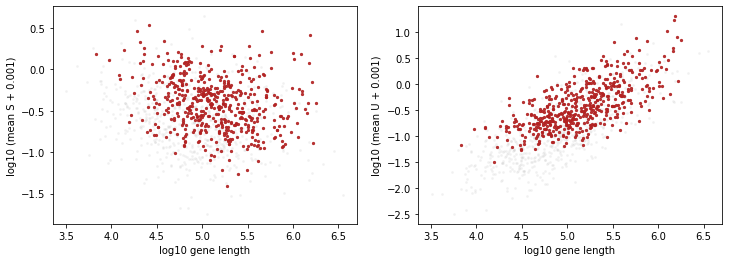

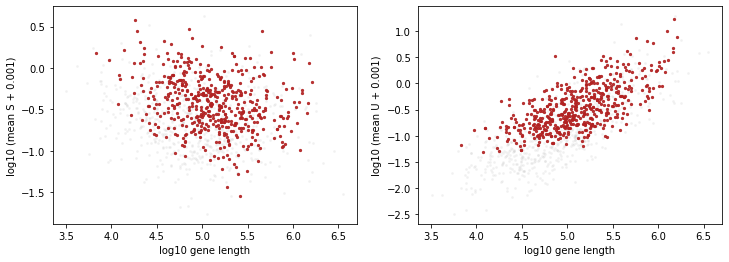

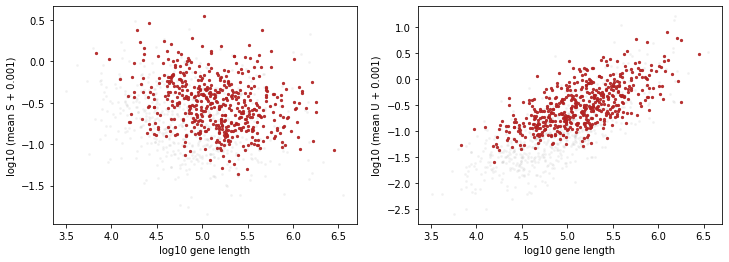

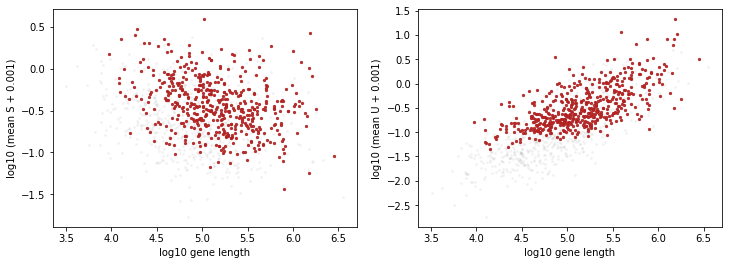

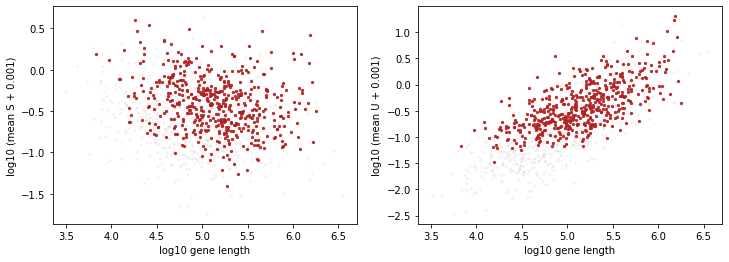

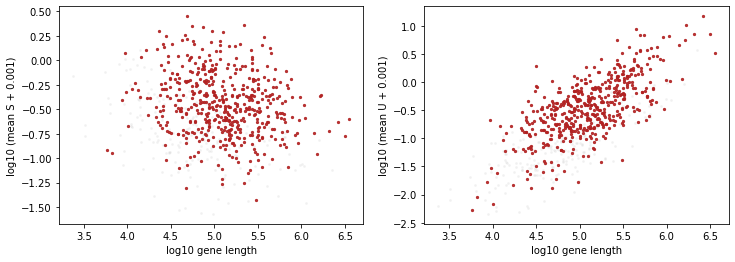

In [63]:
result_strings = []
for i in range(len(data_strings)): 
    #Set biological model
    fitmodel = monod.cme_toolbox.CMEModel('Bursty','Poisson')
    
    #Set up inference params
    inference_parameters = monod.inference.InferenceParameters(phys_lb,phys_ub,samp_lb,samp_ub,gridsize,\
                data_strings[i][0],fitmodel,use_lengths = True,
                gradient_params = {'max_iterations':15,'init_pattern':'moments','num_restarts':1})
    
    #Get object for monod processing (from loom)
    
    search_data = monod.extract_data.extract_data(looms[i], transcrips[i], datas[i],
                data_strings[i][0], dir_strings[i], dataset_attr_names=attribute_names,)
    
    #Run inference
    start = timer()
    full_result_string = inference_parameters.fit_all_grid_points(40,search_data)
    end = timer()
    print((end - start)/3600,' hr')

    result_strings.append(full_result_string)

In [64]:
result_strings

['./fits/meK_techruns_0310/gg_240309_025_drop_1perc_sim_k8_1/drop_1perc_sim_k8/Bursty_Poisson_10x11/grid_scan_results.res',
 './fits/meK_techruns_0310/gg_240309_025_drop_5perc_sim_k8_1/drop_5perc_sim_k8/Bursty_Poisson_10x11/grid_scan_results.res',
 './fits/meK_techruns_0310/gg_240309_025_drop_20perc_sim_k8_1/drop_20perc_sim_k8/Bursty_Poisson_10x11/grid_scan_results.res',
 './fits/meK_techruns_0310/gg_240309_025_negctrl_sim_k1_1/negctrl_sim_k1/Bursty_Poisson_10x11/grid_scan_results.res',
 './fits/meK_techruns_0310/gg_240309_025_b_beta_sim_k8_1/b_beta_sim_k8/Bursty_Poisson_10x11/grid_scan_results.res',
 './fits/meK_techruns_0310/gg_240309_025_k_gamma_sim_k8_1/k_gamma_sim_k8/Bursty_Poisson_10x11/grid_scan_results.res']

drop_1perc_sim_k8   (-6.777777777777778, -1.25)
drop_5perc_sim_k8   (-6.222222222222222, -0.6999999999999997)
drop_20perc_sim_k8   (-6.222222222222222, -0.6999999999999997)
negctrl_sim_k1   (-6.777777777777778, -1.25)
b_beta_sim_k8   (-6.777777777777778, -1.25)
k_gamma_sim_k8   (-6.777777777777778, -1.25)


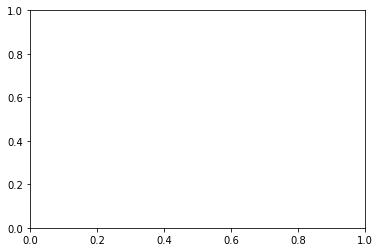

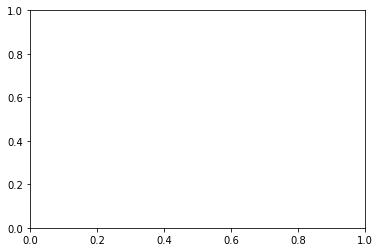

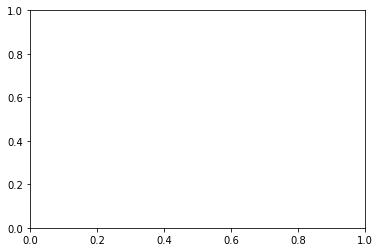

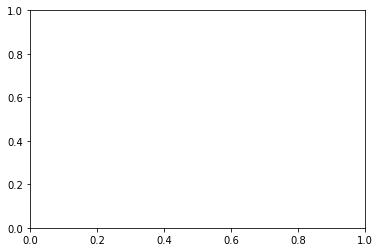

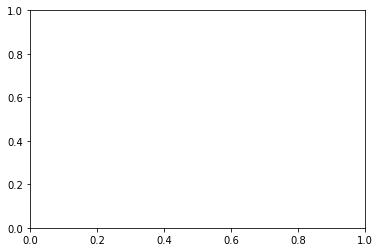

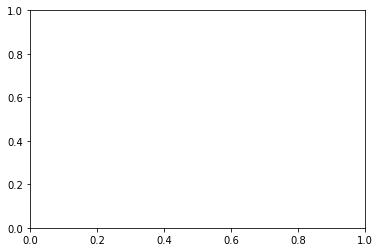

In [65]:
opts = []
for i in range(len(data_strings)): 
    sr = monod.analysis.load_search_results(result_strings[i])
    sd = monod.analysis.load_search_data(dir_strings[i]+'/'+datas[i]+'/raw.sd')
    fig1,ax1 = plt.subplots(1,1)
    sr.find_sampling_optimum()
    print(datas[i],' ',sr.samp_optimum)
    opts += [sr.samp_optimum]

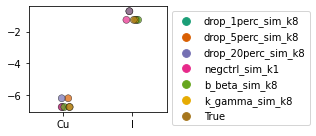

In [133]:
plt.figure(figsize=(4.5,2))
g=sns.stripplot(x=['Cu']*6+['l']*6+['Cu','l'],
                y=list(np.array(opts)[:,0])+list(np.array(opts)[:,1])+[-6.777777777777778, -1.25],
                hue=datas+datas+['True','True'],
                jitter=True,s=7,edgecolor='black',linewidth=0.5,
               palette='Dark2',alpha=0.7)
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))

plt.tight_layout()

plt.savefig('techparams_dropout.pdf')

### **Read in results for analysis**

**Look at ARI/AMI with dropout noise and varying K**

In [185]:
df = pd.read_csv('./fits/meKruns_0309/meK_dropout_results.csv')
df.head()

,Method,Clustering,Matrices,Hyperparam,Genes,Data,ARI,AMI,HVGs
0,meK-Means,1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|...,"U,S",5,1100,drop_1perc_sim_k8,0.783313,0.850990,1100
1,meK-Means,5|5|5|5|5|5|5|5|5|5|5|5|5|5|5|5|5|5|5|5|5|5|5|...,"U,S",10,1100,drop_1perc_sim_k8,0.926881,0.915221,1100
2,meK-Means,7|5|5|7|5|7|5|5|7|7|5|7|5|7|9|7|7|9|10|7|7|7|5...,"U,S",15,1100,drop_1perc_sim_k8,0.885442,0.883764,1100
3,meK-Means,17|17|17|17|17|17|17|17|10|17|17|17|17|17|17|1...,"U,S",20,1100,drop_1perc_sim_k8,0.340968,0.585779,1100
4,meK-Means,4|4|4|4|4|4|4|4|4|4|4|4|4|4|4|4|4|4|4|4|4|4|4|...,"U,S",5,1100,drop_5perc_sim_k8,0.796216,0.859087,1100


In [186]:
np.unique(df.Data)

array(['b_beta_sim_k8', 'drop_1perc_sim_k8', 'drop_20perc_sim_k8',
       'drop_5perc_sim_k8'], dtype=object)

In [187]:
num_clus = [len(np.unique(i.split('|'))) for i in df.Clustering]
df['Num_Clus'] = num_clus
df.head()

,Method,Clustering,Matrices,Hyperparam,Genes,Data,ARI,AMI,HVGs,Num_Clus
0,meK-Means,1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|...,"U,S",5,1100,drop_1perc_sim_k8,0.783313,0.850990,1100,5
1,meK-Means,5|5|5|5|5|5|5|5|5|5|5|5|5|5|5|5|5|5|5|5|5|5|5|...,"U,S",10,1100,drop_1perc_sim_k8,0.926881,0.915221,1100,7
2,meK-Means,7|5|5|7|5|7|5|5|7|7|5|7|5|7|9|7|7|9|10|7|7|7|5...,"U,S",15,1100,drop_1perc_sim_k8,0.885442,0.883764,1100,6
3,meK-Means,17|17|17|17|17|17|17|17|10|17|17|17|17|17|17|1...,"U,S",20,1100,drop_1perc_sim_k8,0.340968,0.585779,1100,3
4,meK-Means,4|4|4|4|4|4|4|4|4|4|4|4|4|4|4|4|4|4|4|4|4|4|4|...,"U,S",5,1100,drop_5perc_sim_k8,0.796216,0.859087,1100,5


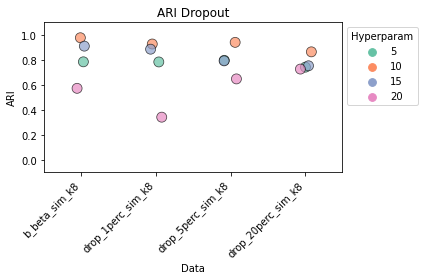

In [191]:
g=sns.stripplot(data=df,x='Data',y='ARI',hue='Hyperparam',
                s=10,alpha=0.7,edgecolor="black",linewidth=0.75,
                       palette='Set2',order=['b_beta_sim_k8','drop_1perc_sim_k8', 'drop_5perc_sim_k8',
       'drop_20perc_sim_k8'])
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))


plt.title('ARI Dropout')  

plt.xticks(rotation = 45,ha='right')
plt.tight_layout()
plt.ylim([-0.1,1.1])
#plt.show()
plt.savefig('ari_dropout.pdf')

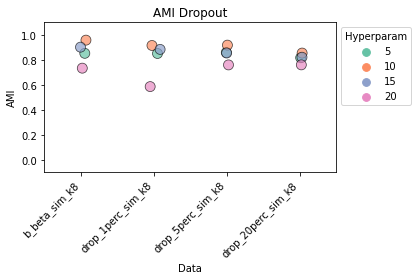

In [192]:
g=sns.stripplot(data=df,x='Data',y='AMI',hue='Hyperparam',
                s=10,alpha=0.7,edgecolor="black",linewidth=0.75,
                       palette='Set2',order=['b_beta_sim_k8','drop_1perc_sim_k8', 'drop_5perc_sim_k8',
       'drop_20perc_sim_k8'])
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))


plt.title('AMI Dropout')  

plt.xticks(rotation = 45,ha='right')
plt.tight_layout()
plt.ylim([-0.1,1.1])
plt.savefig('ami_dropout.pdf')

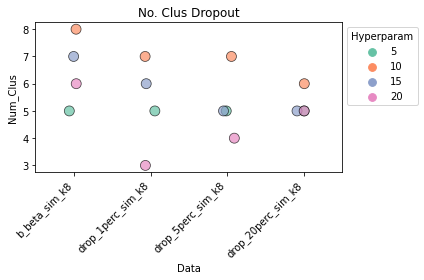

In [193]:
g=sns.stripplot(data=df,x='Data',y='Num_Clus',hue='Hyperparam',
                s=10,alpha=0.7,edgecolor="black",linewidth=0.75,
                       palette='Set2',order=['b_beta_sim_k8','drop_1perc_sim_k8', 'drop_5perc_sim_k8',
       'drop_20perc_sim_k8'])
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))


plt.title('No. Clus Dropout')  

plt.xticks(rotation = 45,ha='right')
plt.tight_layout()
#plt.ylim([-0.1,1.1])
#plt.show()
plt.savefig('numclus_dropout.pdf')

**Look at AIC over k and dropout**

In [142]:
#./fits/meKruns_0309
to_find = ['./fits/meKruns_0309/gg_240309_025_b_beta_sim_k8_K5_1/b_beta_sim_k8/Bursty_Poisson_1x1/*.res',
          './fits/meKruns_0309/gg_240309_025_b_beta_sim_k8_K10_1/b_beta_sim_k8/Bursty_Poisson_1x1/*.res',
          './fits/meKruns_0309/gg_240309_025_b_beta_sim_k8_K15_1/b_beta_sim_k8/Bursty_Poisson_1x1/*.res',
          './fits/meKruns_0309/gg_240309_025_b_beta_sim_k8_K20_1/b_beta_sim_k8/Bursty_Poisson_1x1/*.res',
          './fits/meKruns_0309/gg_240309_025_drop_1perc_sim_k8_K5_1/drop_1perc_sim_k8/Bursty_Poisson_1x1/*.res',
          './fits/meKruns_0309/gg_240309_025_drop_1perc_sim_k8_K10_1/drop_1perc_sim_k8/Bursty_Poisson_1x1/*.res',
          './fits/meKruns_0309/gg_240309_025_drop_1perc_sim_k8_K15_1/drop_1perc_sim_k8/Bursty_Poisson_1x1/*.res',
          './fits/meKruns_0309/gg_240309_025_drop_1perc_sim_k8_K20_1/drop_1perc_sim_k8/Bursty_Poisson_1x1/*.res',
          './fits/meKruns_0309/gg_240309_025_drop_5perc_sim_k8_K5_1/drop_5perc_sim_k8/Bursty_Poisson_1x1/*.res',
          './fits/meKruns_0309/gg_240309_025_drop_5perc_sim_k8_K10_1/drop_5perc_sim_k8/Bursty_Poisson_1x1/*.res',
          './fits/meKruns_0309/gg_240309_025_drop_5perc_sim_k8_K15_1/drop_5perc_sim_k8/Bursty_Poisson_1x1/*.res',
          './fits/meKruns_0309/gg_240309_025_drop_5perc_sim_k8_K20_1/drop_5perc_sim_k8/Bursty_Poisson_1x1/*.res',
          './fits/meKruns_0309/gg_240309_025_drop_20perc_sim_k8_K5_1/drop_20perc_sim_k8/Bursty_Poisson_1x1/*.res',
          './fits/meKruns_0309/gg_240309_025_drop_20perc_sim_k8_K10_1/drop_20perc_sim_k8/Bursty_Poisson_1x1/*.res',
          './fits/meKruns_0309/gg_240309_025_drop_20perc_sim_k8_K15_1/drop_20perc_sim_k8/Bursty_Poisson_1x1/*.res',
          './fits/meKruns_0309/gg_240309_025_drop_20perc_sim_k8_K20_1/drop_20perc_sim_k8/Bursty_Poisson_1x1/*.res']

result_strings = []
for f in to_find:
    result_strings += [glob.glob(f)]

In [147]:
col_all_par = '#4472C4'
col_b = '#1B9AAA'
col_beta = '#9fcbee'
col_gamma ='#3C50B1'
col_expr = '#9299A0'


In [148]:
def check_at_bounds(phys_params,thr=0.01,phys_lb=[-2.0, -1.8, -1.8 ],phys_ub=[4.2, 2.5, 2.5]):
    #Check for genes where parameter fits are close to boundary of grid
    x = np.any(np.logical_or(
        np.array(phys_lb)+thr > phys_params,
        np.array(phys_ub)-thr < phys_params) ,1)
    return x

In [149]:
def get_assigns(sr):
    '''
    Get cell cluster assignments
    '''
    cats = np.array([None]*len(sr[0].filt))
    for r in sr:
        cats[r.filt] = r.assigns
    return cats

In [150]:
#Plot cluster concordance with true labels and distribution of clusters

def vis_assign(assign,true=None,title='',log=True,figsize=(18, 5),palette='tab20',fname=None):
    '''
    Plot distribution of cluster assignments (optional: with previous annotations)

    assign: np.array of cluster assignments (1..k) for each cell
    true: list of user-given cluster assignments (string) for each cell, optional
    title: title string for cluster assignment plot
    figsize: tuple for size of figure
    save_file: string, output file to save image

    '''
 
    #Plot cluster assignments and distribution of sizes of each cluster
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figsize)

    if true is not None:
        hues = true
    else:
        hues = assign 
        
    if log:
        plt.yscale('log')
    
    g= sns.histplot(x=assign,hue=hues,hue_order=list(np.unique(hues)), kde=False,ax=ax,
                    palette=palette,multiple="dodge",
                    discrete=True)

    plt.xticks(np.arange(0,np.max(assign)+1))
    


    ax.set_xlabel('meK-Means Cluster Assignment')
    ax.set_title(title)
    sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))


    plt.tight_layout()
    if fname is None:
        plt.show()
    else:
        plt.savefig(fname)



In [151]:
def vis_metrics(results,title,ks,figsize=(18, 5),s=50,fname=None):
    '''
    Visualize -Q function and KLD over epochs, and -AIC for final model inference

    results: list of len num_ks, of lists of SearchResults objs per K tested (e.g. [[SearchResults],[SearchResults,SearchResults]] for K=1&2)
    title: title string for leftmost, plot
    ks: list of ks tested (e.g. [1,2])
    figsize: tuple for size of figure
    s: size of dots in scatterplot
    save_file: string, output file to save image

  '''

    num_ks = len(results)
    sets = []
    qs = []
    res = pd.DataFrame()
    aics = pd.DataFrame()
    klds = pd.DataFrame()

    aic = []
    fin_k = []
    kls = []

    epoch = len(results[0][0].all_qs.flatten())
    epos = list(range(1,epoch+1))*num_ks

    for i in range(num_ks):

        qs += list(-1*results[i][0].all_qs.flatten())
        sets += [ks[i]]*epoch
        aic += [results[i][0].aic[0]]
        fin_k += [len(results[i])]


        concat_klds = []
        ks_used = []
        for r in results[i]:
            concat_klds += [r.all_klds[0,:,:]]
            ks_used += [r.assigns]

        concat_klds = np.array(concat_klds)
        concat_klds = concat_klds.reshape((concat_klds.shape[1], concat_klds.shape[2],concat_klds.shape[0]))

        kls += list(np.mean(np.sum(concat_klds[:,:,:],axis=1),axis=1)) #Sum of klds across k clusters


    res['Q'] = qs
    res['KLD'] = kls
    res['epoch'] = epos
    res['setting'] = ['k='+str(j) for j in sets]

    aics['AIC'] = aic
    aics['k'] = [str(j) for j in ks ]
    aics['fin_k'] = fin_k

    #Plot Q function over epochs
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=figsize)

    sns.lineplot(data=res,x='epoch',y='Q',hue='setting',
                    ax=ax[0],palette='Dark2',
                   alpha=0.7,legend=False)
    g1=sns.scatterplot(data=res,x='epoch',y='Q',hue='setting',
                    ax=ax[0],palette='Dark2',s=s,
                   alpha=0.7,edgecolor='black')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('-Q')
    ax[0].legend(
          title='Set K')
    ax[0].set_title(title)
    sns.move_legend(g1, "upper left", bbox_to_anchor=(1, 1))


    #Plot klds over epochs
    g2=sns.lineplot(data=res,x='epoch',y='KLD',hue='setting',
                    ax=ax[1],palette='Dark2',
                   alpha=0.7,legend=False)
    sns.scatterplot(data=res,x='epoch',y='KLD',hue='setting',
                    ax=ax[1],palette='Dark2',s=s,
                   alpha=0.7,edgecolor='black')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('KLD')
    ax[1].legend(
          title='Set K')
    sns.move_legend(g2, "upper left", bbox_to_anchor=(1, 1))



    #Plot aics
    g3=sns.scatterplot(data=aics,x='fin_k',y='AIC',hue='k', ax=ax[2],palette='Dark2',s=s,
                   alpha=0.7,edgecolor='black')
    ax[2].set_xlabel('Final Assigned k')
    ax[2].set_ylabel('-AIC')
    ax[2].legend(
          title='Set K')
    sns.move_legend(g3, "upper left", bbox_to_anchor=(1, 1))


    plt.tight_layout()
    if fname is None:
        plt.show()
    else:
        plt.savefig(fname)


In [194]:
def vis_q_aic(results,title,ks,figsize=(18, 5),s=50,fname=None):
    '''
    Visualize -Q function and -AIC for final model inference

    results: list of len num_ks, of lists of SearchResults objs per K tested (e.g. [[SearchResults],[SearchResults,SearchResults]] for K=1&2)
    title: title string for leftmost, plot
    ks: list of ks tested (e.g. [1,2])
    figsize: tuple for size of figure
    s: size of dots in scatterplot
    save_file: string, output file to save image

  '''

    num_ks = len(results)
    sets = []
    qs = []
    res = pd.DataFrame()
    aics = pd.DataFrame()
    klds = pd.DataFrame()

    aic = []
    fin_k = []
    kls = []

    epoch = len(results[0][0].all_qs.flatten())
    epos = list(range(1,epoch+1))*num_ks

    for i in range(num_ks):

        qs += list(-1*results[i][0].all_qs.flatten())
        sets += [ks[i]]*epoch
        aic += [results[i][0].aic[0]]
        fin_k += [len(results[i])]


        concat_klds = []
        ks_used = []
        for r in results[i]:
            concat_klds += [r.all_klds[0,:,:]]
            ks_used += [r.assigns]

        concat_klds = np.array(concat_klds)
        concat_klds = concat_klds.reshape((concat_klds.shape[1], concat_klds.shape[2],concat_klds.shape[0]))

        kls += list(np.mean(np.sum(concat_klds[:,:,:],axis=1),axis=1)) #Sum of klds across k clusters


    res['Q'] = qs
    res['KLD'] = kls
    res['epoch'] = epos
    res['setting'] = ['k='+str(j) for j in sets]

    aics['AIC'] = aic
    aics['k'] = [str(j) for j in ks ]
    aics['fin_k'] = fin_k

    #Plot Q function over epochs
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=figsize)

    sns.lineplot(data=res,x='epoch',y='Q',hue='setting',
                    ax=ax[0],palette='Dark2',
                   alpha=0.7,legend=False)
    g1=sns.scatterplot(data=res,x='epoch',y='Q',hue='setting',
                    ax=ax[0],palette='Dark2',s=s,
                   alpha=0.7,edgecolor='black')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('-Q')
    ax[0].legend(
          title='Set K')
    ax[0].set_title(title)
    sns.move_legend(g1, "upper left", bbox_to_anchor=(1, 1))



    #Plot aics
    g3=sns.scatterplot(data=aics,x='k',y='AIC',hue='k', ax=ax[1],palette='Dark2',s=s,
                   alpha=0.7,edgecolor='black')
    ax[1].set_xlabel('Set K')
    ax[1].set_ylabel('-AIC')
    ax[1].legend(
          title='Set K')
    sns.move_legend(g3, "upper left", bbox_to_anchor=(1, 1))


    plt.tight_layout()
    if fname is None:
        plt.show()
    else:
        plt.savefig(fname)


In [152]:
def print_summary(sr):
    '''
    Get summary of clustering results
    '''
    print('--------------------------')
    print('Model AIC Score: ',sr[0].aic[0])
    for r in sr:
        print('Clus '+str(r.assigns)+' with '+str(np.sum(r.filt))+' cells')
    print('--------------------------')

In [153]:
sr = [] #SearchResults for each dataset
for strings in result_strings:
    sr += [[monod.analysis.load_search_results(i) for i in strings]]

len(sr)

16

In [155]:
#SearchData objects, with U/S
sd = []
for strings in result_strings:

    sd += [[monod.analysis.load_search_data(i[:i.find('Bursty')]+'raw.sd') for i in strings]]

len(sd)

16

b_beta_sim_k8_metrics.pdf
drop_1perc_sim_k8_metrics.pdf
drop_5perc_sim_k8_metrics.pdf
drop_20perc_sim_k8_metrics.pdf


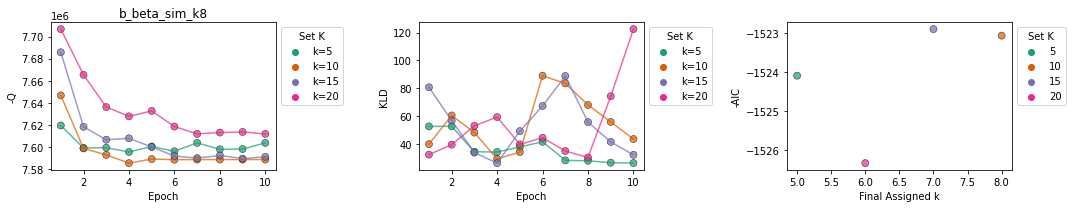

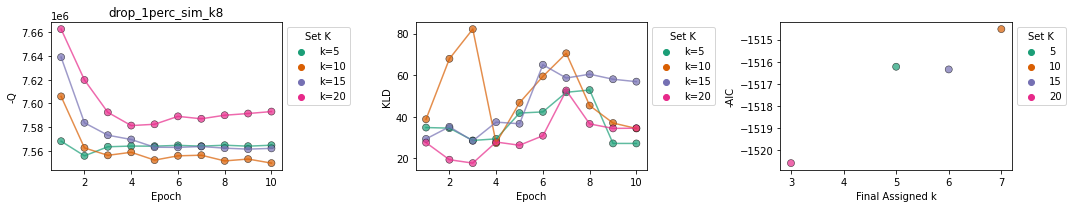

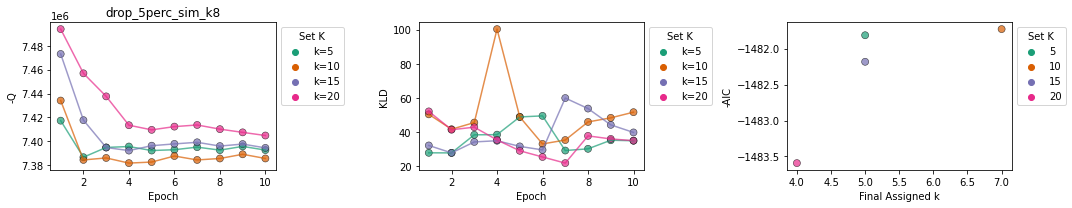

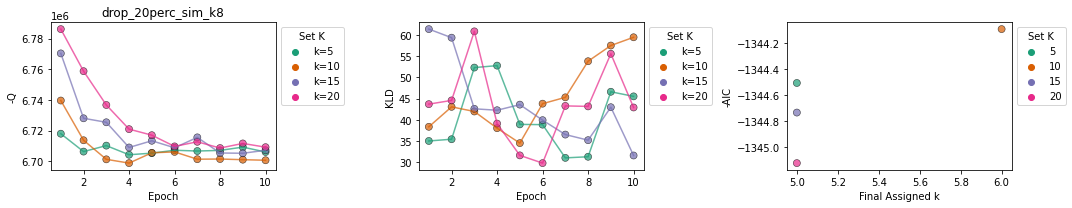

In [180]:
#Plot AICs over Ks for each dataset
import re

for i in range(0,len(sr),4):
    dash_inds = [m.start() for m in re.finditer('/', to_find[i])]
    data_name = to_find[i][dash_inds[3]+1:dash_inds[4]]
    vis_metrics(sr[i:i+4],data_name,Ks,figsize=(15,3),fname=data_name+'_metrics.pdf')
    print(data_name+'_metrics.pdf')

b_beta_sim_k8_q_aic.pdf
drop_1perc_sim_k8_q_aic.pdf
drop_5perc_sim_k8_q_aic.pdf
drop_20perc_sim_k8_q_aic.pdf


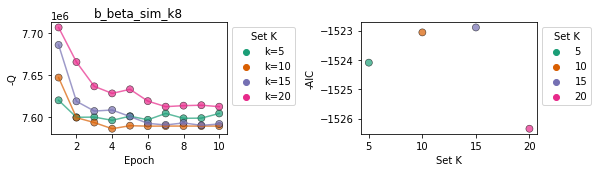

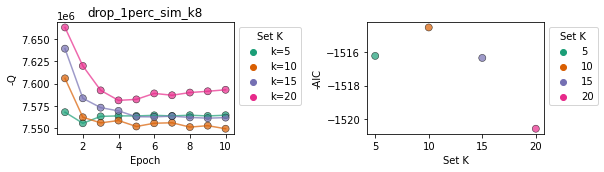

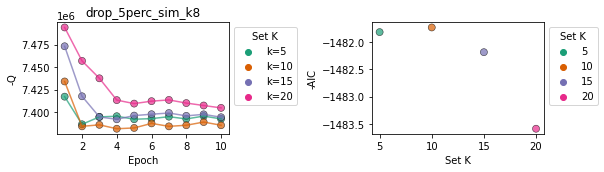

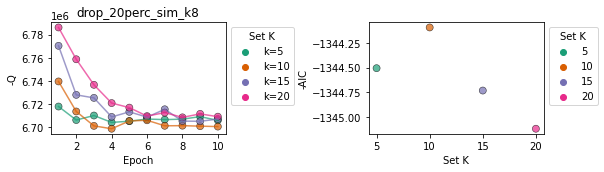

In [201]:

for i in range(0,len(sr),4):
    dash_inds = [m.start() for m in re.finditer('/', to_find[i])]
    data_name = to_find[i][dash_inds[3]+1:dash_inds[4]]
    vis_q_aic(sr[i:i+4],data_name,Ks,figsize=(8.5,2.5),fname=data_name+'_q_aic.pdf')
    print(data_name+'_q_aic.pdf')

**Look at param correlations to true params**